### Trading Data Analysis Notebook

This notebook performs an in-depth analysis of trading data to uncover patterns, identify outliers, and derive actionable insights for improving trading strategies. The dataset includes trade records (test_task_trades.csv) and account details (test_task_accounts.csv). The analysis involves data preprocessing, exploratory data analysis (EDA), outlier handling, and advanced feature analysis to understand trade performance across various dimensions.

##### Objectives

- Merge and clean the trade and account datasets to create a reliable dataset.
- Conduct exploratory data analysis to understand distributions, relationships, and outliers.
- Handle missing values and outliers to improve data quality.
- Analyze numerical, categorical, and time-based features to identify profitability drivers.
- Summarize insights to guide trading strategy optimization.

#### 1. Setup and Data Loading

**Objective:** Import necessary libraries and load the trade and account datasets to prepare for analysis.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [31]:
df_trades = pd.read_csv('../data/raw/test_task_trades.csv', index_col=False)
df_accounts = pd.read_csv('../data/raw/test_task_accounts.csv', index_col=False)

In [32]:
print(df_trades.shape)
print(df_accounts.shape)

(1083719, 20)
(84227, 6)


#### 2. Data Merging and Initial Validation

**Objective:** Merge the trade and account datasets on the trading_account_login and login columns to create a unified dataset, and validate the merge integrity.

**Steps:**

- Merge datasets using a left join to retain all trade records.
- Verify that trading_account_login matches login for all records.
- Check for null values in key columns (trading_account_login, login).
- Print the shape of the merged DataFrame to confirm the merge.

In [33]:
merged_df = pd.merge(df_trades, df_accounts, left_on='trading_account_login', right_on='login', how='left')

In [34]:
print('Shape of merged DataFrame:', merged_df.shape)

print('Are all trading_account_login values equal to login?', 
      (merged_df['trading_account_login'] == merged_df['login']).all())

print('Any null values in trading_account_login or login?\n', 
      merged_df[['trading_account_login', 'login']].isna().any())


Shape of merged DataFrame: (1083719, 26)
Are all trading_account_login values equal to login? True
Any null values in trading_account_login or login?
 trading_account_login    False
login                    False
dtype: bool


- The merged DataFrame retains all 1083719 trade records, with account details appended.
- All trading_account_login values match login, confirming a perfect merge.
- No null values in trading_account_login or login, indicating robust data linkage.

#### 3. Data Cleaning: Dropping and Renaming Columns

**Objective:** Remove redundant or unnecessary columns and rename columns for clarity to streamline the dataset.

**Steps:**
- Drop columns Unnamed: 0, platform_x, and trading_account_login as they are either redundant or not needed.
- Rename platform_y to platform for clarity.
- Convert opened_at and closed_at to datetime format for time-based analysis.

In [35]:

columns_to_drop = ['Unnamed: 0', 'platform_x', 'trading_account_login']
merged_df.drop(columns=columns_to_drop, inplace=True)

merged_df.rename(columns={'platform_y': 'platform'}, inplace=True)

merged_df['opened_at'] = pd.to_datetime(merged_df['opened_at'])
merged_df['closed_at'] = pd.to_datetime(merged_df['closed_at'])

print("\nData Types after conversion:")
print(merged_df[['opened_at', 'closed_at']].dtypes)


Data Types after conversion:
opened_at    datetime64[ns]
closed_at    datetime64[ns]
dtype: object


In [36]:
merged_df.head()

,identifier,action,reason,open_price,close_price,commission,lot_size,opened_at,closed_at,pips,...,swap,symbol,contract_size,profit_rate,login,account_size,platform,phase,user_id,challenge_id
0,44041186,0,16.0,3332.900,3332.880,-0.07,0.01,2025-05-05 23:41:50,2025-05-06 00:00:10,0.2,...,0.0,XAUUSD,100.0,1.000000,10452073,5000,0,3,535946,4793871
1,44045174,1,16.0,19921.400,19924.870,0.00,0.84,2025-05-05 23:58:19,2025-05-06 00:01:17,34.7,...,0.0,NDX100,20.0,1.000000,10480427,50000,0,0,1259367,3271436
2,44038318,1,16.0,143.654,143.756,-1.50,0.75,2025-05-05 23:27:58,2025-05-06 00:01:52,10.2,...,0.0,USDJPY,100000.0,0.006957,10464074,10000,0,0,533885,1158518
3,44042511,1,16.0,143.655,143.757,-1.50,0.75,2025-05-05 23:48:20,2025-05-06 00:01:58,10.2,...,0.0,USDJPY,100000.0,0.006957,10464074,10000,0,0,533885,1158518
4,44046179,0,16.0,3333.370,3333.270,-2.00,1.00,2025-05-06 00:00:49,2025-05-06 00:02:00,1.0,...,0.0,XAUUSD,100.0,1.000000,10451614,100000,0,1,969510,2064915


In [37]:
merged_df.columns

Index(['identifier', 'action', 'reason', 'open_price', 'close_price',
       'commission', 'lot_size', 'opened_at', 'closed_at', 'pips', 'price_sl',
       'price_tp', 'profit', 'swap', 'symbol', 'contract_size', 'profit_rate',
       'login', 'account_size', 'platform', 'phase', 'user_id',
       'challenge_id'],
      dtype='object')

#### 4. Initial Exploratory Data Analysis (EDA)

**Objective:** Perform initial EDA to understand the dataset's structure, identify missing values, and summarize numerical and categorical features.

**Steps:**

- Display dataset info and summary statistics.
- Visualize missing values using a heatmap.
- Analyze unique values and counts for categorical columns (action, reason, symbol, platform, phase).
- Check for duplicates in identifier columns (identifier, login, user_id, challenge_id).

In [38]:
print(merged_df.info())
print(merged_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083719 entries, 0 to 1083718
Data columns (total 23 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   identifier     1083719 non-null  int64         
 1   action         1083719 non-null  int64         
 2   reason         726724 non-null   float64       
 3   open_price     1083719 non-null  float64       
 4   close_price    1083719 non-null  float64       
 5   commission     1083719 non-null  float64       
 6   lot_size       1083719 non-null  float64       
 7   opened_at      1083719 non-null  datetime64[ns]
 8   closed_at      1083719 non-null  datetime64[ns]
 9   pips           1083719 non-null  float64       
 10  price_sl       600586 non-null   float64       
 11  price_tp       505960 non-null   float64       
 12  profit         1083719 non-null  float64       
 13  swap           1083719 non-null  float64       
 14  symbol         1083719 non-null  o

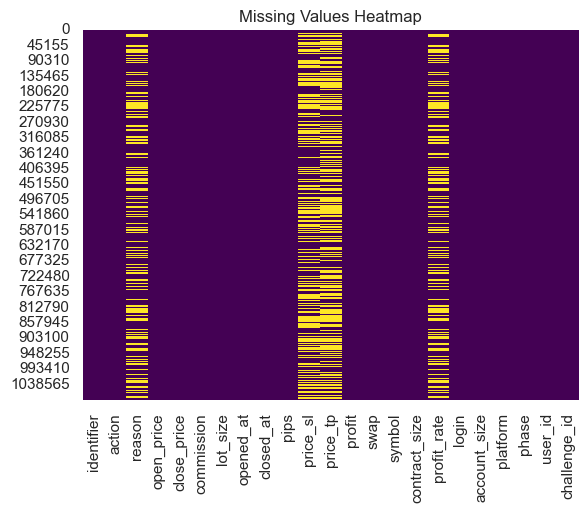

In [39]:
sns.heatmap(merged_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

From the above plot we can see missing values over `reason` , `price_sl`, `price_tp`, `profit_rate`

#### EDA: Categorical Values


In [40]:
print("\n--- Unique values and Value Counts for Categorical/Discrete Columns ---")

categorical_cols = ['action', 'reason', 'symbol', 'platform', 'phase']
for col in categorical_cols:
    print(f"\nColumn: '{col}'")
    print(f"Unique values: {merged_df[col].nunique()}")
    print(f"Value Counts:\n{merged_df[col].value_counts(dropna=False).to_markdown()}")


id_cols = ['identifier', 'login', 'user_id', 'challenge_id']
for col in id_cols:
    print(f"\nColumn: '{col}'")
    print(f"Unique values: {merged_df[col].nunique()}")
    print(f"Duplicates (beyond first): {merged_df[col].duplicated().sum()}")


--- Unique values and Value Counts for Categorical/Discrete Columns ---

Column: 'action'
Unique values: 2
Value Counts:
|   action |   count |
|---------:|--------:|
|        0 |  629411 |
|        1 |  454308 |

Column: 'reason'
Unique values: 8
Value Counts:
|   reason |   count |
|---------:|--------:|
|       16 |  560944 |
|      nan |  356995 |
|        0 |  107930 |
|       17 |   36817 |
|        1 |   17093 |
|        5 |    3848 |
|        3 |      63 |
|        4 |      15 |
|        2 |      14 |

Column: 'symbol'
Unique values: 61
Value Counts:
| symbol   |   count |
|:---------|--------:|
| XAUUSD   |  586158 |
| EURUSD   |  122510 |
| NDX100   |   92526 |
| GBPUSD   |   53061 |
| USDJPY   |   40111 |
| DJI30    |   27373 |
| GER40    |   21631 |
| GBPJPY   |   19425 |
| BTCUSD   |   19074 |
| AUDUSD   |   11617 |
| SPX500   |    9066 |
| USDCAD   |    8773 |
| USDCHF   |    5402 |
| NZDUSD   |    5218 |
| EURJPY   |    5086 |
| ETHUSD   |    5006 |
| XAGUSD   |    4466

**Insights Gained:**
- Missing values detected in reason, price_sl, price_tp, and profit_rate (e.g., ~42% for price_sl, ~52% for price_tp).
- Numerical features show high skewness (e.g., profit, lot_size, pips), indicating potential outliers.
- Categorical columns reveal diverse trading symbols (e.g., EURUSD, XAUUSD) and platforms, with action limited to two types (0, 1).
- Identifier columns show expected duplicates (e.g., login reused across trades), confirming dataset structure.

#### 5. Numerical Feature Distribution Analysis

**Objective:** Analyze the distribution of numerical features to identify skewness, outliers, and patterns.

**Steps:**

* Visualize distributions of numerical columns (open_price, close_price, commission, lot_size, pips, profit, swap, account_size, price_sl, price_tp, profit_rate) using histograms and boxplots.

* Compute and display the correlation matrix for numerical features.

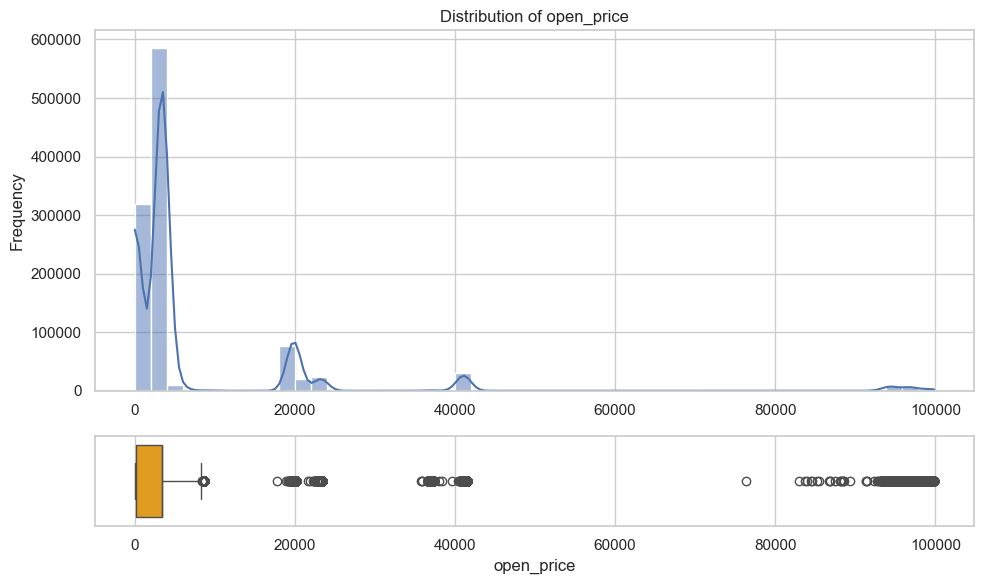

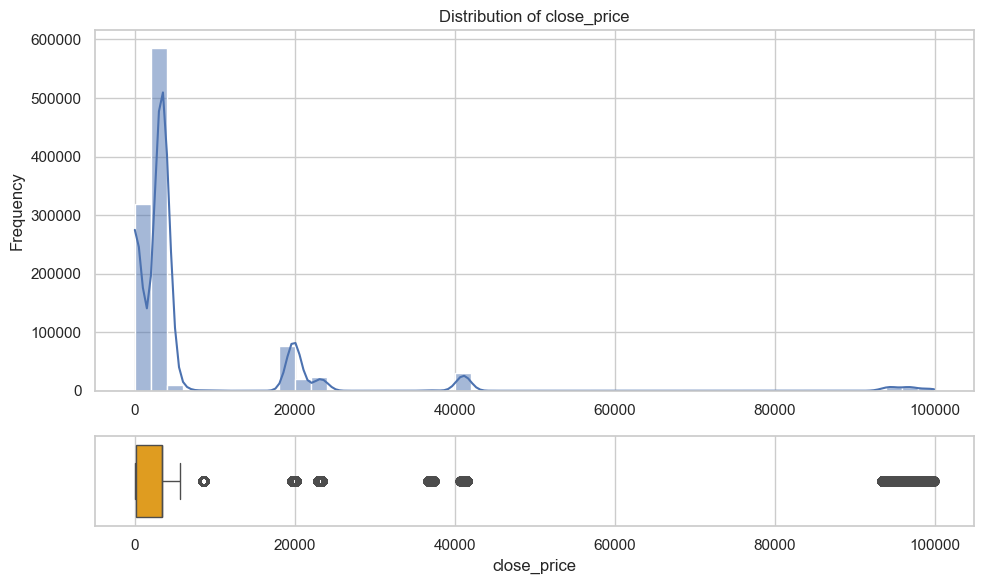

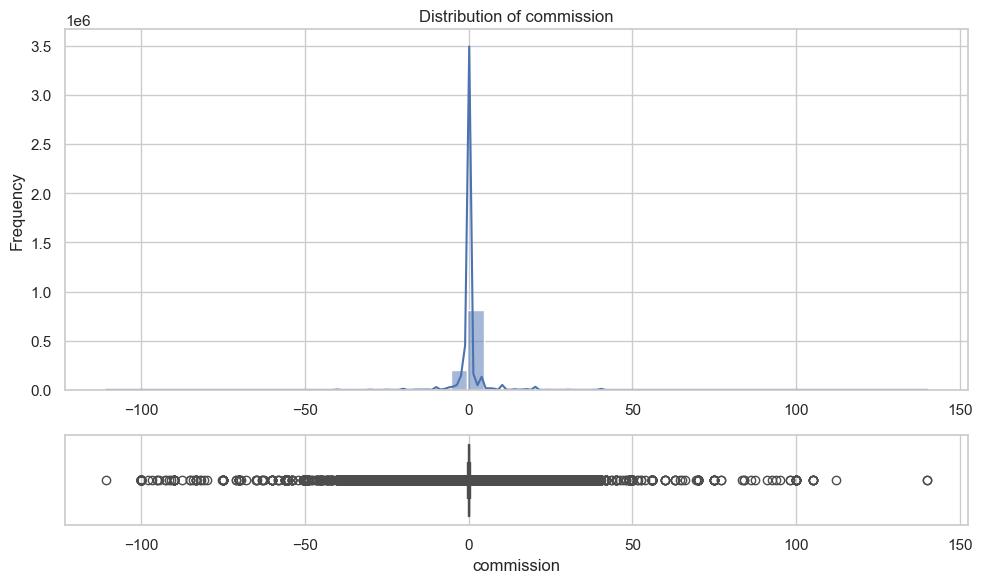

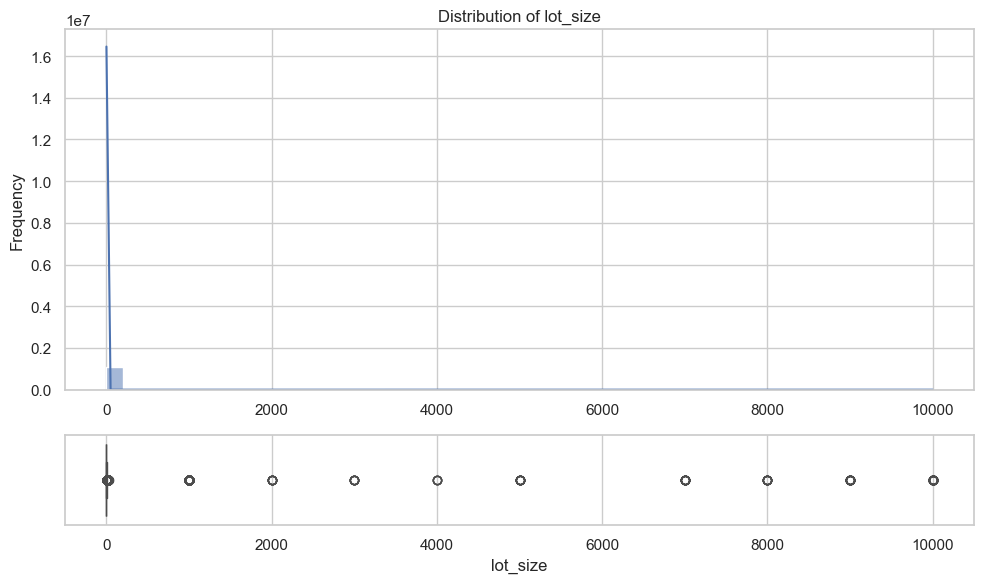

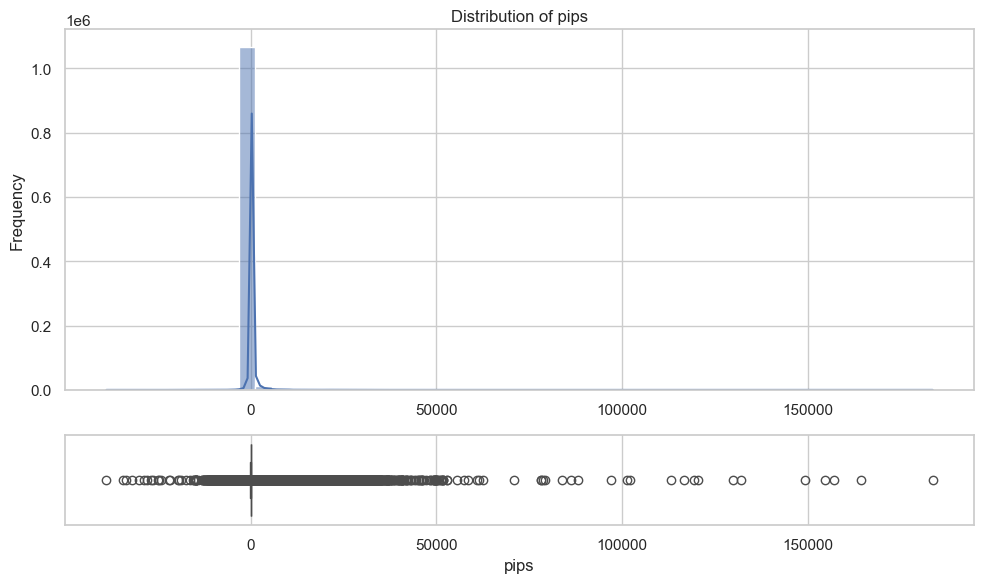

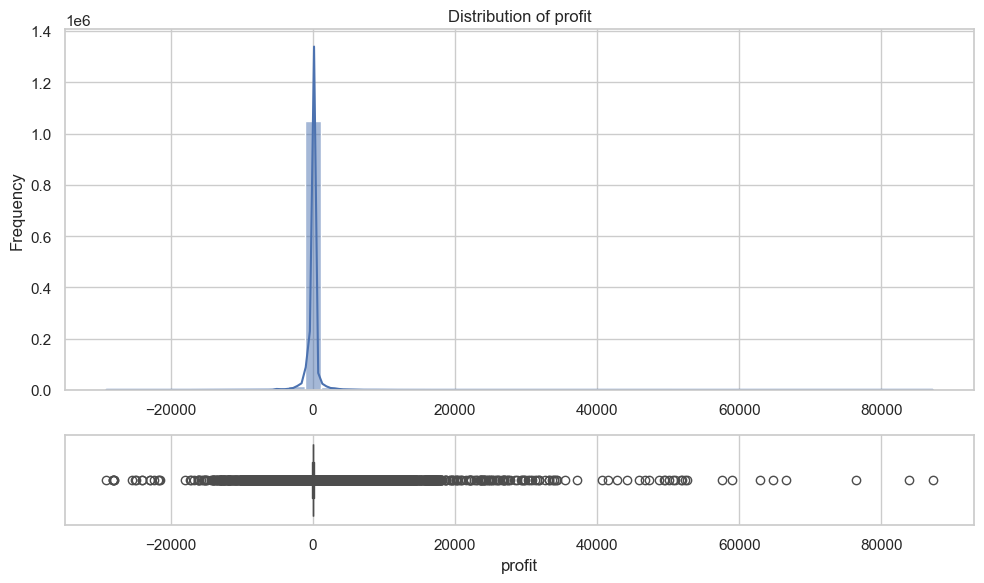

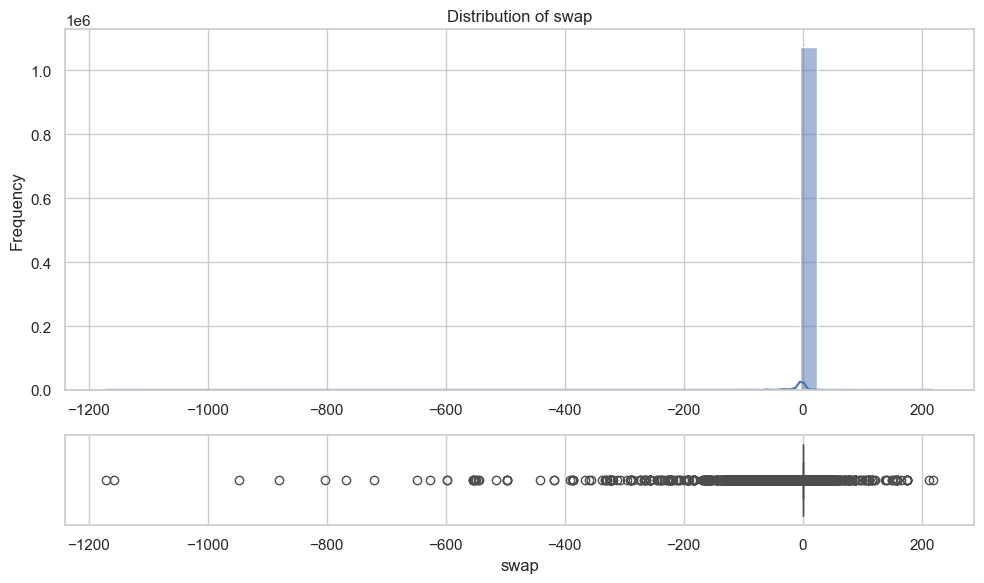

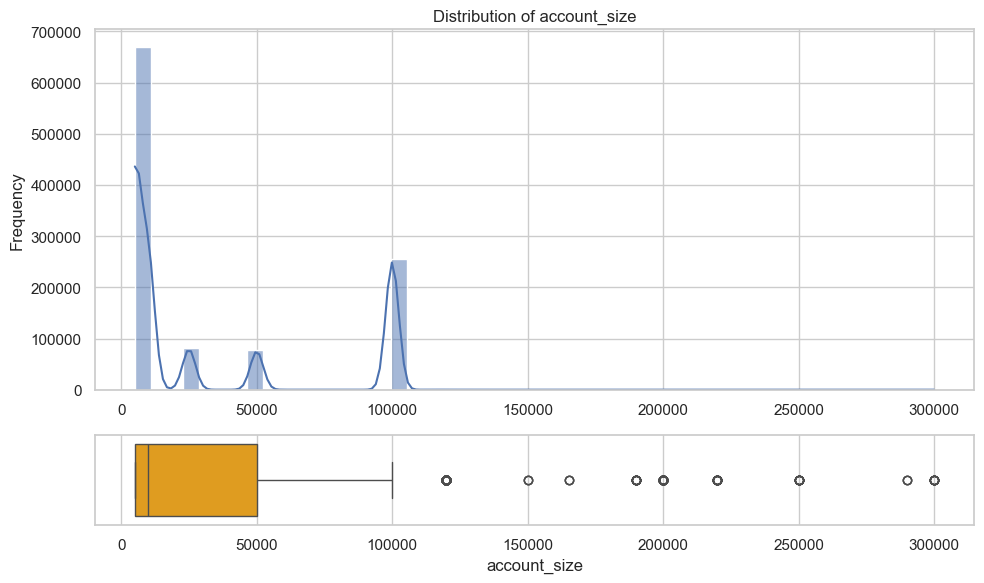

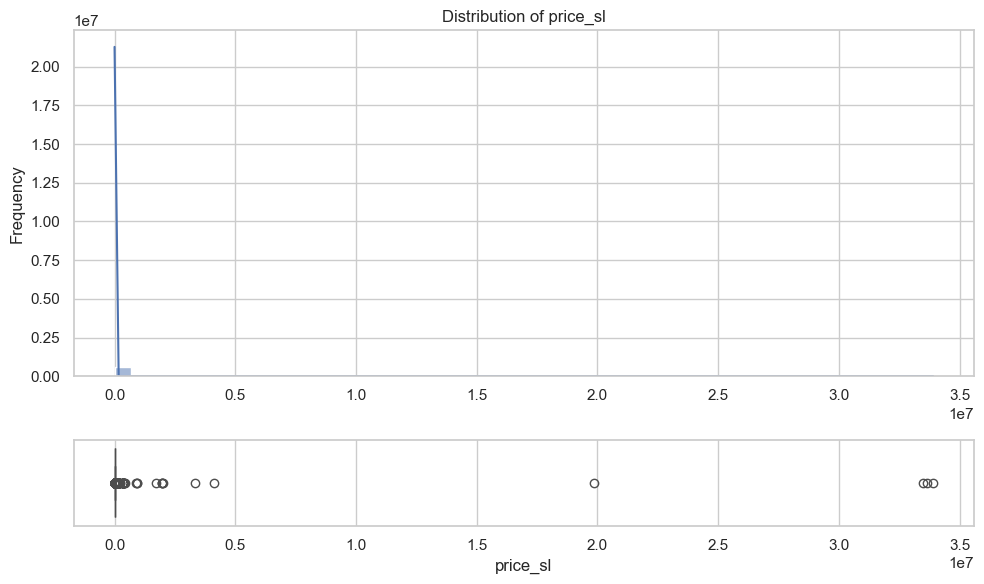

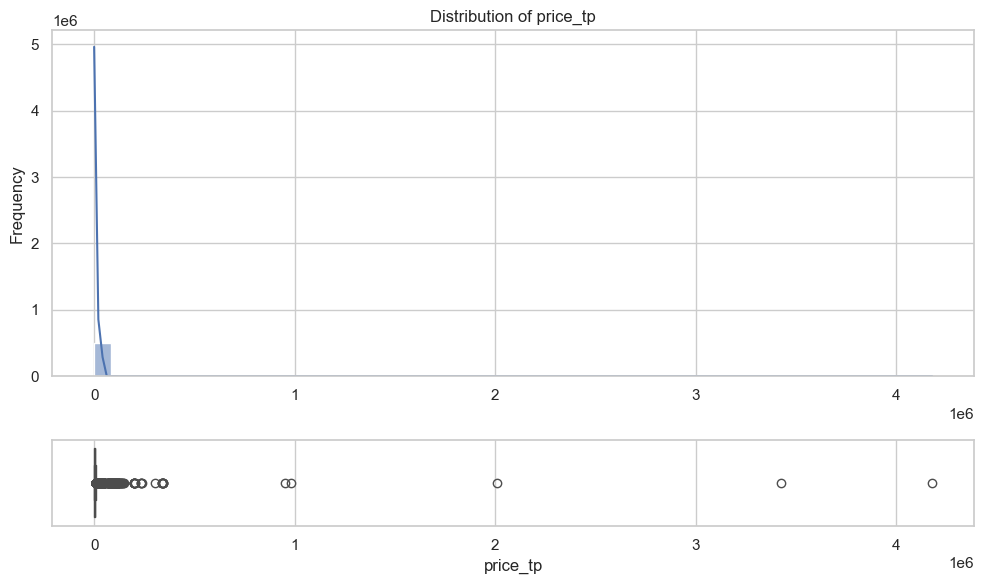

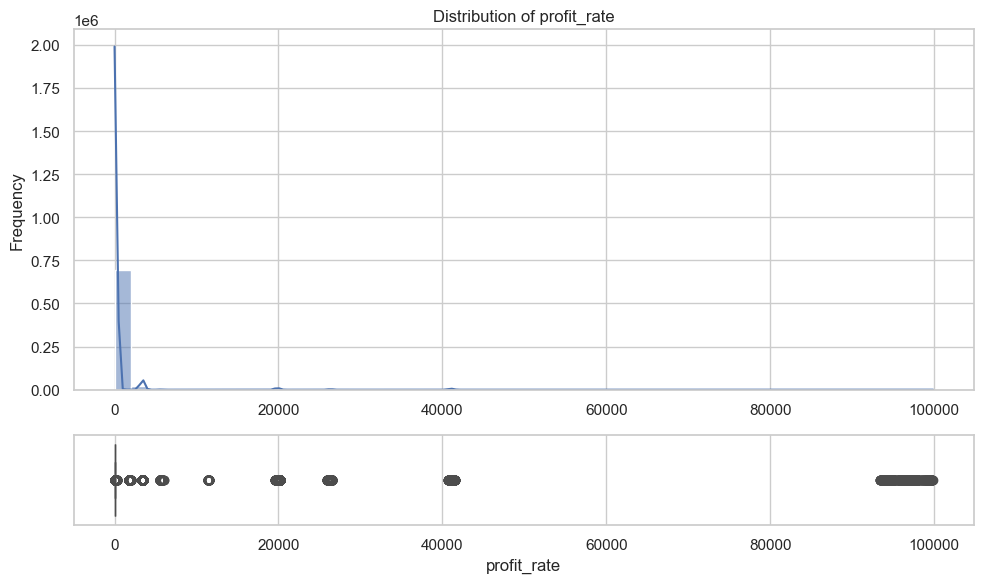

In [41]:
import matplotlib.gridspec as gridspec

numerical_cols = [
    'open_price', 'close_price', 'commission', 'lot_size', 'pips',
    'profit', 'swap', 'account_size', 'price_sl', 'price_tp', 'profit_rate'
]

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    
    ax0 = plt.subplot(gs[0])
    sns.histplot(merged_df[col].dropna(), bins=50, kde=True, ax=ax0)
    ax0.set_title(f'Distribution of {col}')
    ax0.set_xlabel('')
    ax0.set_ylabel('Frequency')
    
    ax1 = plt.subplot(gs[1], sharex=ax0)
    sns.boxplot(x=merged_df[col].dropna(), ax=ax1, color='orange')
    ax1.set_xlabel(col)
    ax1.set_yticks([])

    plt.tight_layout()
    plt.show()

In [42]:
merged_df['contract_size'].value_counts()

contract_size
100.0       414104
1.0         256681
100000.0    195059
1000.0      112053
20.0         59512
5.0          20702
25.0         14057
50.0          5748
10.0          4229
5000.0        1574
Name: count, dtype: int64

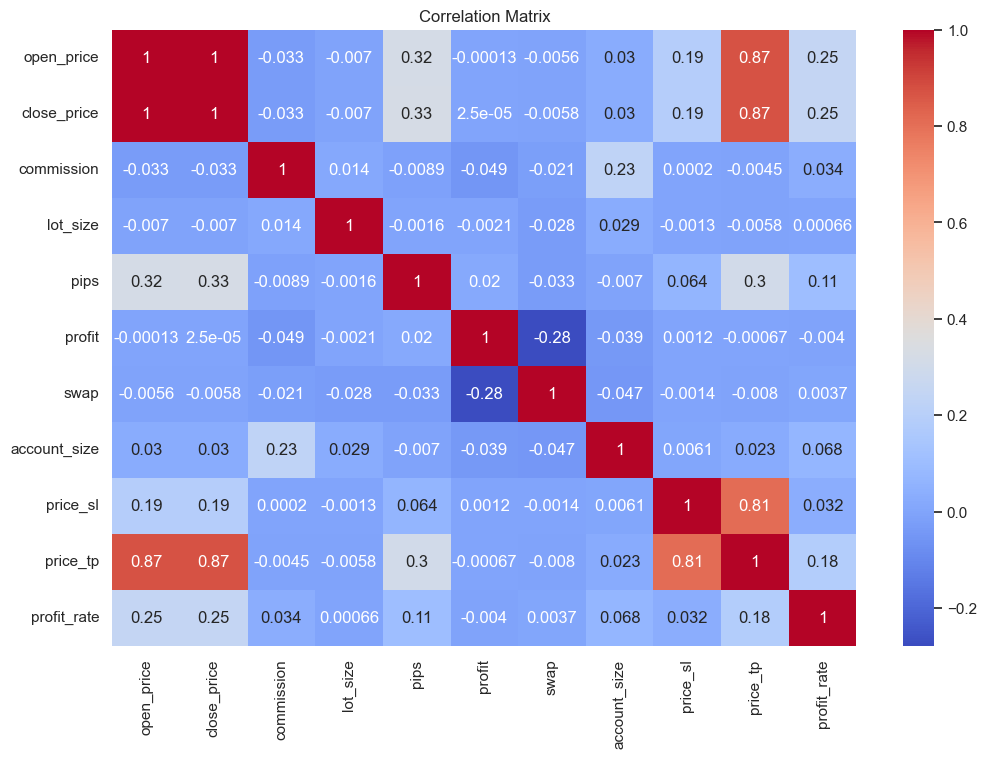

In [43]:
corr = merged_df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


**Insights Gained:**
- Most numerical features (open_price, close_price, lot_size, pips, profit_rate) are right-skewed with significant outliers.
- commission, profit, and swap are centered around zero, reflecting both gains and losses.
- Strong Correlations: open_price and close_price are perfectly correlated (1.0), while profit and price_tp show a notable correlation (0.3). Additionally, lot_size and commission exhibit a strong negative correlation (-0.14), suggesting lower fees with larger trades.
- Weak Correlation: profit and profit_rate show almost no linear relationship (-0.004), indicating potential non-linear dynamics that could be explored with advanced models.

#### 6. Categorical vs. Numerical Relationships

**Objective:** Explore relationships between categorical variables (action, reason, symbol, platform) and numerical outcomes (profit) to identify performance differences.

**Steps:**
- Visualize profit distributions by action, reason, and symbol using boxplots and barplots.
- Count trades per platform to assess platform usage.

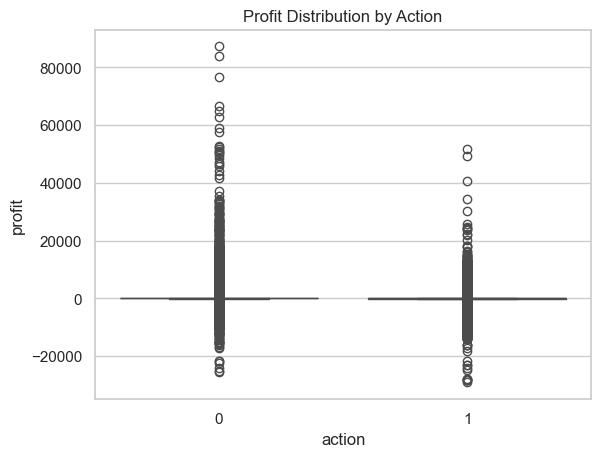

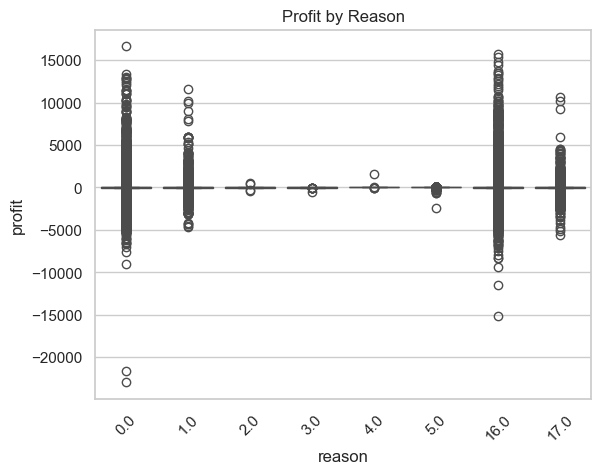

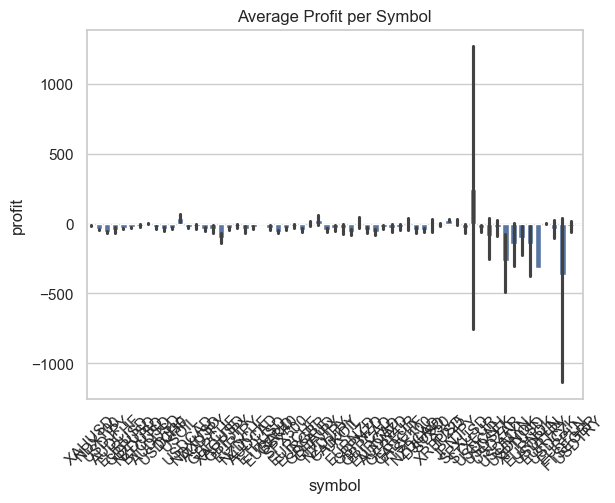

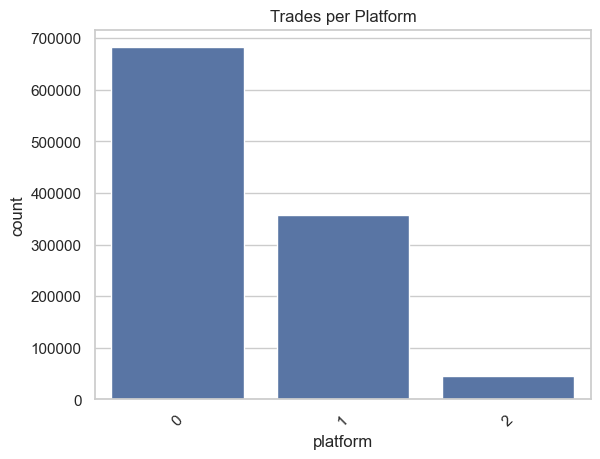

In [44]:

sns.boxplot(x='action', y='profit', data=merged_df)
plt.title("Profit Distribution by Action")
plt.show()

sns.boxplot(x='reason', y='profit', data=merged_df)
plt.xticks(rotation=45)
plt.title("Profit by Reason")
plt.show()

sns.barplot(x='symbol', y='profit', data=merged_df, estimator=np.mean)
plt.title("Average Profit per Symbol")
plt.xticks(rotation=45)
plt.show()

sns.countplot(x='platform', data=merged_df)
plt.title("Trades per Platform")
plt.xticks(rotation=45)
plt.show()


**Insights Gained:**

- Action 0 has smaller losses and higher win rate than Action 1 (-17.86, 43.5%).
- XAUUSD shows the widest profit range, indicating high volatility; other symbols (e.g., EURUSD) cluster near zero.
- Platform 0 has more trades but both platforms (0, 2) operate at a loss, with Platform 2 worse (-17.5 vs. -10).
- `reason` analysis suggests variability in trade closure reasons impacting profitability.

In [45]:
merged_df['opened_at'] = pd.to_datetime(merged_df['opened_at'])
merged_df['closed_at'] = pd.to_datetime(merged_df['closed_at'])


#### 7. Time-Based Analysis

**Objective:** Analyze temporal patterns in trades to understand profit trends and trade frequency over time.

**Steps:**
- Plot cumulative profit over time using opened_at as the index.
- Visualize daily trade counts to identify trading activity patterns.

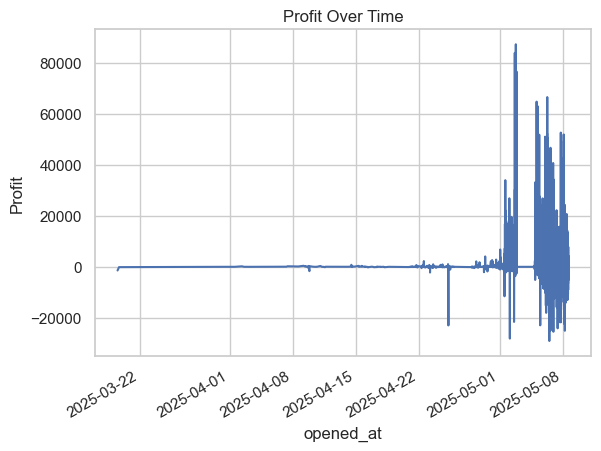

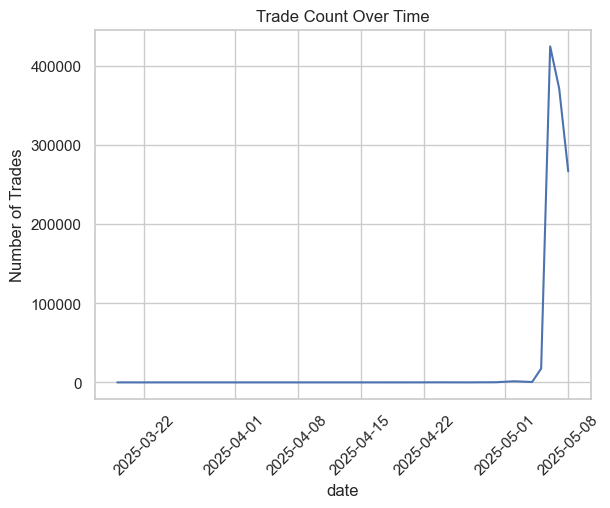

In [46]:

df = merged_df.sort_values('opened_at')
df.set_index('opened_at')['profit'].plot()
plt.title("Profit Over Time")
plt.ylabel("Profit")
plt.show()

# Number of trades per day
df['date'] = df['opened_at'].dt.date
df['date'].value_counts().sort_index().plot()
plt.title("Trade Count Over Time")
plt.ylabel("Number of Trades")
plt.xticks(rotation=45)
plt.show()


#### 8. Outlier Analysis

**Objective:** Identify and quantify outliers in key numerical features (profit_rate, lot_size, pips) to assess their impact on analysis.

**Steps:**
- Compute percentiles (1%, 5%, 95%, 99%) for profit_rate, lot_size, and pips.
- Count records in each percentile range to quantify outlier prevalence.
- Group by symbol to analyze feature distributions across different instruments.

In [47]:
# Check detailed percentiles
profit_rate_percentiles = merged_df['profit_rate'].quantile([0.01, 0.05, 0.95, 0.99])
lot_size_percentiles = merged_df['lot_size'].quantile([0.01, 0.05, 0.95, 0.99])
pips_percentiles = merged_df['pips'].quantile([0.01, 0.05, 0.95, 0.99])
print()
print("\nProfit Rate Percentiles:", profit_rate_percentiles.to_markdown())
print("\nLot Size Percentiles:", lot_size_percentiles.to_markdown())
print("\nPips Percentiles:", pips_percentiles.to_markdown())




Profit Rate Percentiles: |      |    profit_rate |
|-----:|---------------:|
| 0.01 |     0.00693943 |
| 0.05 |     0.00700584 |
| 0.95 |     1.32662    |
| 0.99 | 19762          |

Lot Size Percentiles: |      |   lot_size |
|-----:|-----------:|
| 0.01 |       0.01 |
| 0.05 |       0.01 |
| 0.95 |       4.2  |
| 0.99 |      10.01 |

Pips Percentiles: |      |    pips |
|-----:|--------:|
| 0.01 | -463.7  |
| 0.05 |  -53.4  |
| 0.95 |  361.9  |
| 0.99 | 1745.88 |


In [48]:
profit_rate_bounds = merged_df['profit_rate'].quantile([0.01, 0.05, 0.95, 0.99])
lot_size_bounds = merged_df['lot_size'].quantile([0.01, 0.05, 0.95, 0.99])
pips_bounds = merged_df['pips'].quantile([0.01, 0.05, 0.95, 0.99])

# --- Profit Rate ---
print("\nProfit Rate Quantile Counts:")
print("Below 1%:", (merged_df['profit_rate'] < profit_rate_bounds[0.01]).sum())
print("1%–5%:", ((merged_df['profit_rate'] >= profit_rate_bounds[0.01]) & (merged_df['profit_rate'] < profit_rate_bounds[0.05])).sum())
print("5%–95%:", ((merged_df['profit_rate'] >= profit_rate_bounds[0.05]) & (merged_df['profit_rate'] <= profit_rate_bounds[0.95])).sum())
print("95%–99%:", ((merged_df['profit_rate'] > profit_rate_bounds[0.95]) & (merged_df['profit_rate'] <= profit_rate_bounds[0.99])).sum())
print("Above 99%:", (merged_df['profit_rate'] > profit_rate_bounds[0.99]).sum())

# --- Lot Size ---
print("\nLot Size Quantile Counts:")
print("Below 1%:", (merged_df['lot_size'] < lot_size_bounds[0.01]).sum())
print("1%–5%:", ((merged_df['lot_size'] >= lot_size_bounds[0.01]) & (merged_df['lot_size'] < lot_size_bounds[0.05])).sum())
print("5%–95%:", ((merged_df['lot_size'] >= lot_size_bounds[0.05]) & (merged_df['lot_size'] <= lot_size_bounds[0.95])).sum())
print("95%–99%:", ((merged_df['lot_size'] > lot_size_bounds[0.95]) & (merged_df['lot_size'] <= lot_size_bounds[0.99])).sum())
print("Above 99%:", (merged_df['lot_size'] > lot_size_bounds[0.99]).sum())

# --- Pips ---
print("\nPips Quantile Counts:")
print("Below 1%:", (merged_df['pips'] < pips_bounds[0.01]).sum())
print("1%–5%:", ((merged_df['pips'] >= pips_bounds[0.01]) & (merged_df['pips'] < pips_bounds[0.05])).sum())
print("5%–95%:", ((merged_df['pips'] >= pips_bounds[0.05]) & (merged_df['pips'] <= pips_bounds[0.95])).sum())
print("95%–99%:", ((merged_df['pips'] > pips_bounds[0.95]) & (merged_df['pips'] <= pips_bounds[0.99])).sum())
print("Above 99%:", (merged_df['pips'] > pips_bounds[0.99]).sum())


Profit Rate Quantile Counts:
Below 1%: 7262
1%–5%: 29048
5%–95%: 654077
95%–99%: 29069
Above 99%: 7268

Lot Size Quantile Counts:
Below 1%: 0
1%–5%: 0
5%–95%: 1029540
95%–99%: 43591
Above 99%: 10588

Pips Quantile Counts:
Below 1%: 10835
1%–5%: 43305
5%–95%: 975400
95%–99%: 43341
Above 99%: 10838


##### Data Outlier Analysis Summary:

Our analysis of the profit_rate, lot_size, and pips columns revealed the following:

- Approximately 2% of the data (1% at each tail) in profit_rate and pips are extreme outliers that could skew the analysis.

- For lot_size, the upper 5% contain large values that may distort results, while the lower extreme values are negligible.

- Winsorization had limited effect on profit_rate due to severe skewness and the distribution of values.

Suggested Approach:

To improve data quality and reduce the impact of outliers, it is recommended to drop rows where values fall outside the 1st and 99th percentiles for profit_rate and pips, and outside the 1st and 99th percentiles for lot_size. This approach balances removing extreme values while retaining the majority of the data for reliable analysis.

##### Data Engineering part

Now let's fix the issues we found while doing EDA, Missing values, Outliers, then after that we will again explore our data analysis step

#### 9. Asset Class Classification

**Objective:** Classify trading symbols into asset classes (Forex, Crypto, Metals, Indices, Commodities) to analyze behavior by asset type.

**Steps:**
- Define lists of symbols for each asset class.
- Create a function to map symbols to asset classes.
- Apply the mapping to create an asset_class column.
- Visualize distributions of profit_rate, pips, and lot_size by asset class.

In [49]:
merged_df.groupby('symbol')['pips'].describe()


,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AUDCAD,2207.0,7.704894,14.805204,-60.3,1.100,5.50,13.250,131.2
AUDCHF,1333.0,6.991673,16.560755,-59.2,0.400,4.30,11.300,220.5
AUDJPY,4029.0,4.678009,20.924712,-119.7,-4.500,2.90,11.600,212.0
AUDNZD,885.0,8.076723,14.455935,-57.7,1.300,5.10,13.200,119.6
AUDUSD,11617.0,4.696686,12.586353,-93.6,0.400,3.40,8.600,120.7
...,...,...,...,...,...,...,...,...
USOIL,4277.0,27.265046,55.360169,-298.5,2.600,15.90,39.000,542.7
XAGUSD,4466.0,4.680900,17.541988,-81.3,-1.400,2.80,7.900,112.9
XAUUSD,586158.0,35.068936,90.973396,-917.5,3.600,18.70,49.000,2590.9


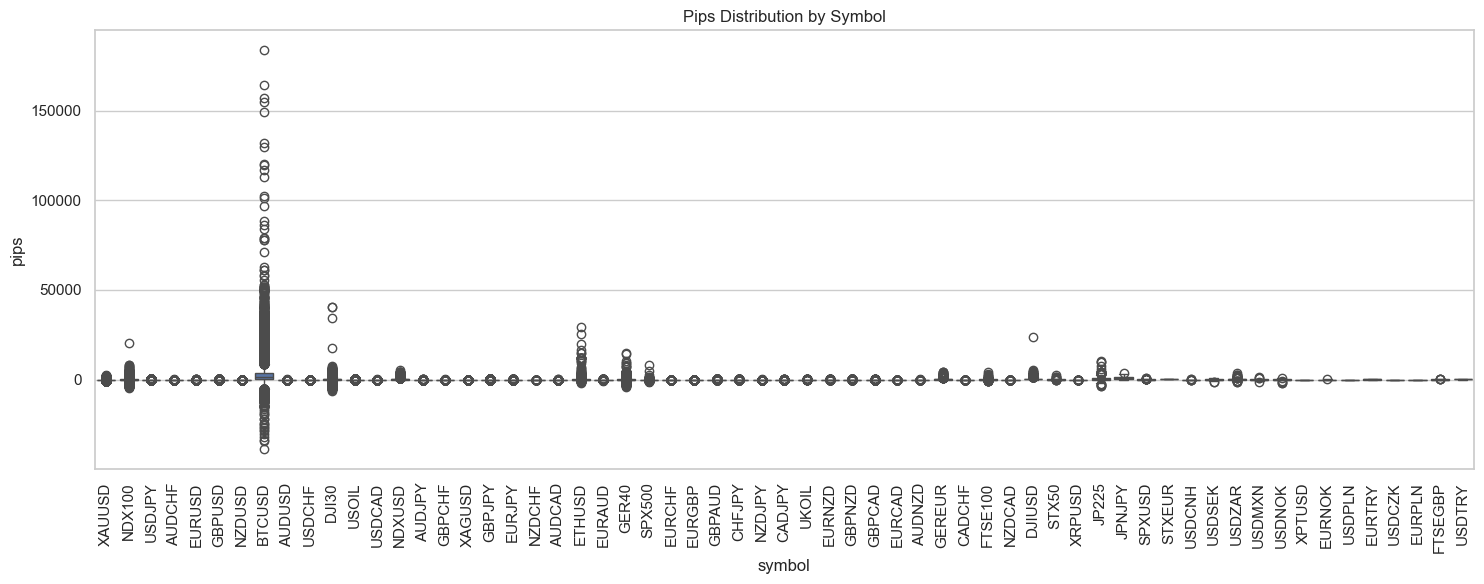

In [50]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='symbol', y='pips', data=merged_df)
plt.xticks(rotation=90)
plt.title('Pips Distribution by Symbol')
plt.tight_layout()
plt.show()

The distribution of pips varies significantly across different symbols, reflecting the inherent volatility and price scale of each instrument. Forex pairs generally show lower average pip values (e.g., EURUSD: 8.28, GBPUSD: 11.36), while cryptocurrencies (BTCUSD: 722.21, ETHUSD: 309.44) and indices (DJI30: 392.38, GER40: 292.82) exhibit much higher pip movements. This indicates a strong dependency of pips on the asset type, and highlights the need for symbol-aware analysis or normalization in further modeling.

In [51]:
print(merged_df.groupby('symbol')['lot_size'].describe())


           count         mean          std   min     25%      50%      75%  \
symbol                                                                       
AUDCAD    2207.0     1.333335     3.019295  0.01  0.1000     0.25     1.00   
AUDCHF    1333.0     1.242566     3.092138  0.01  0.0800     0.20     0.80   
AUDJPY    4029.0     3.504927     4.485454  0.01  0.2000     1.00    10.00   
AUDNZD     885.0     1.192960     2.906610  0.01  0.0800     0.25     0.90   
AUDUSD   11617.0     1.963846     3.669484  0.01  0.1300     0.50     1.50   
...          ...          ...          ...   ...     ...      ...      ...   
USOIL     4277.0     0.546897     1.408474  0.01  0.0300     0.10     0.40   
XAGUSD    4466.0     0.786373     1.910733  0.01  0.0200     0.10     1.00   
XAUUSD  586158.0     0.397840     1.008520  0.01  0.0200     0.07     0.25   
XPTUSD      14.0     0.192857     0.344527  0.01  0.0125     0.10     0.10   
XRPUSD     358.0  2623.558659  3599.278422  1.00  1.0000  1000.0

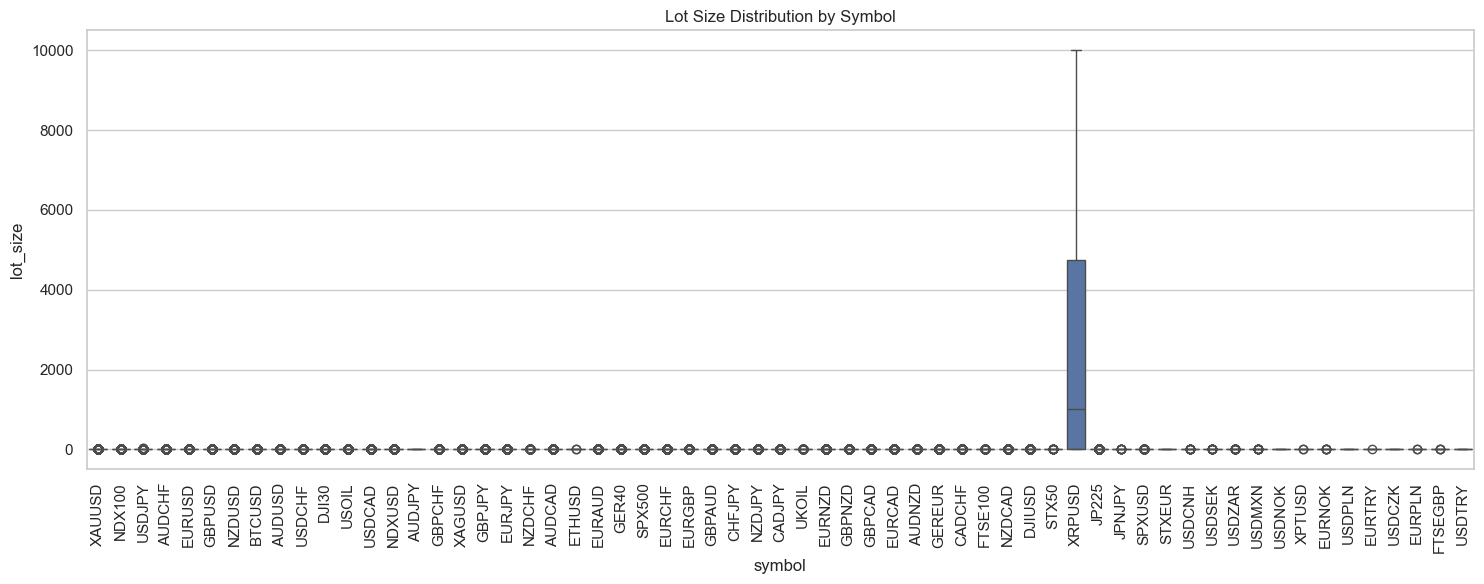

In [52]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='symbol', y='lot_size', data=merged_df)
plt.xticks(rotation=90)
plt.title('Lot Size Distribution by Symbol')
plt.tight_layout()
plt.show()


The lot_size distribution varies widely across symbols, with most forex pairs trading with average lot sizes below 2, often clustering near small fractional lots (e.g., AUDCAD mean ≈ 1.33, AUDUSD mean ≈ 1.96). Precious metals like XAUUSD show smaller average lot sizes (~0.40), while some assets like XRPUSD exhibit extreme outliers with very large lot sizes (mean over 2600, max 10,000), indicating highly variable trade sizes or potentially institutional-level trades. The capped maximum lot size of 20 for many symbols suggests standardization or trading limits in place for most instruments.

In [53]:
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Optionally, set max column width to avoid truncation
pd.set_option('display.max_colwidth', None)

profit_rate_stats = df.groupby('symbol')['profit_rate'].describe()
print(profit_rate_stats)

            count          mean           std           min           25%  \
symbol                                                                      
AUDCAD     1485.0      0.721170      0.014669      0.640880      0.723003   
AUDCHF      912.0      1.201012      0.085607      0.640470      1.211798   
AUDJPY     1559.0      0.051645      0.162990      0.006900      0.006955   
AUDNZD      630.0      0.599213      0.009490      0.591820      0.596603   
AUDUSD     6900.0      0.973997      0.092344      0.640260      1.000000   
BTCUSD    10433.0   5992.495229  23249.628271      1.000000      1.000000   
CADCHF      544.0      1.198638      0.085280      0.720710      1.211424   
CADJPY     1164.0      0.084614      0.222953      0.006898      0.006959   
CHFJPY      767.0      0.076164      0.280670      0.006900      0.006961   
DJI30     18346.0      1.000000      0.000000      1.000000      1.000000   
DJIUSD     2356.0  41063.077453    157.466259  40683.790000  40955.332500   

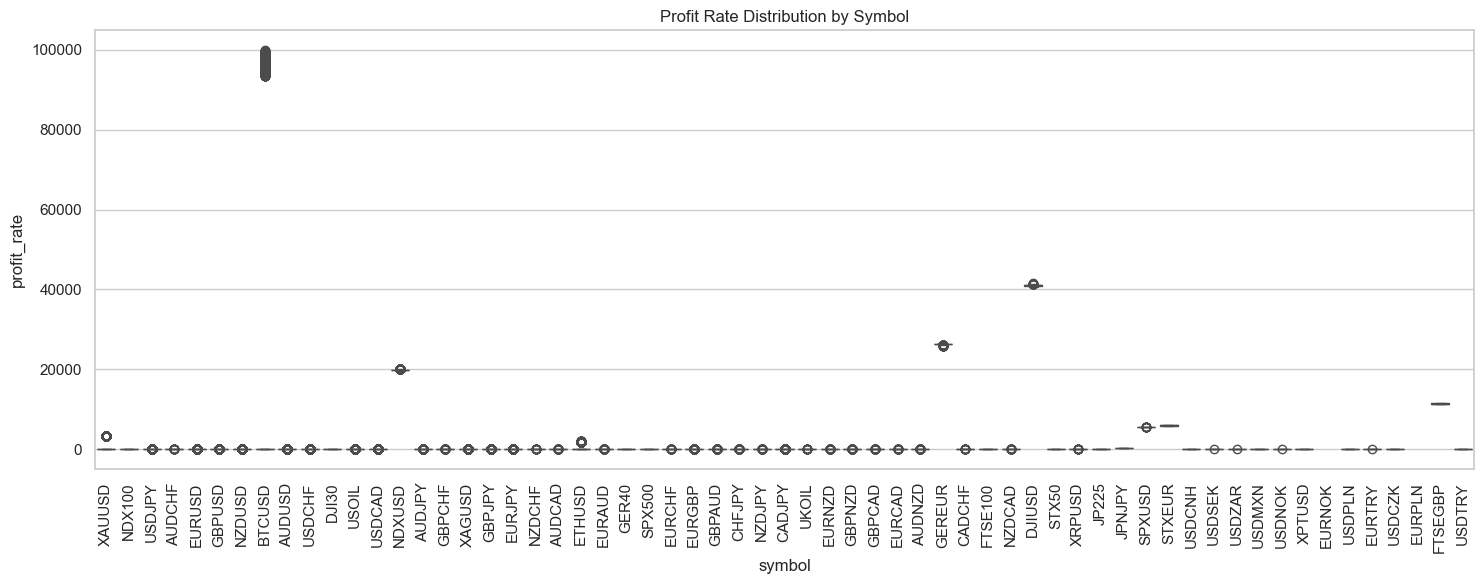

In [54]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='symbol', y='profit_rate', data=merged_df)
plt.xticks(rotation=90)
plt.title('Profit Rate Distribution by Symbol')
plt.tight_layout()
plt.show()


- Most Forex pairs (like AUDUSD, EURUSD, GBPUSD) show average profit rates close to 1.0 with low variability, indicating stable and consistent returns.

- Crypto pairs like BTCUSD and ETHUSD have very high mean profit rates but also extremely high variability and large outliers, suggesting occasional very large gains or losses.

- Precious metals such as XAUUSD (Gold) also display notable variability in profit rates.

- Some symbols (e.g., EURNOK, EURPLN) have no trade data available.

- Overall, stable currency pairs tend to have tight profit rate distributions, while crypto and commodity pairs show wider profit fluctuations.

In [55]:
# Get unique symbols
unique_symbols = merged_df['symbol'].unique()
print("Unique symbols:", unique_symbols)


Unique symbols: ['XAUUSD' 'NDX100' 'USDJPY' 'AUDCHF' 'EURUSD' 'GBPUSD' 'NZDUSD' 'BTCUSD'
 'AUDUSD' 'USDCHF' 'DJI30' 'USOIL' 'USDCAD' 'NDXUSD' 'AUDJPY' 'GBPCHF'
 'XAGUSD' 'GBPJPY' 'EURJPY' 'NZDCHF' 'AUDCAD' 'ETHUSD' 'EURAUD' 'GER40'
 'SPX500' 'EURCHF' 'EURGBP' 'GBPAUD' 'CHFJPY' 'NZDJPY' 'CADJPY' 'UKOIL'
 'EURNZD' 'GBPNZD' 'GBPCAD' 'EURCAD' 'AUDNZD' 'GEREUR' 'CADCHF' 'FTSE100'
 'NZDCAD' 'DJIUSD' 'STX50' 'XRPUSD' 'JP225' 'JPNJPY' 'SPXUSD' 'STXEUR'
 'USDCNH' 'USDSEK' 'USDZAR' 'USDMXN' 'USDNOK' 'XPTUSD' 'EURNOK' 'USDPLN'
 'EURTRY' 'USDCZK' 'EURPLN' 'FTSEGBP' 'USDTRY']


Classify each trading symbol into its corresponding asset class (e.g., Forex, Crypto, Metals, etc.)
This helps in analyzing and handling outliers separately for each asset class, as behavior and scales vary significantly.

- **Forex**: Currency pairs traded in the foreign exchange market. These are highly liquid and typically follow macroeconomic trends, central bank policies, and geopolitical events.
- **Crypto**: Digital assets like Bitcoin, Ethereum, and Ripple. Known for high volatility and trading around the clock.
- **Metals**: Precious metals such as Gold (XAU), Silver (XAG), and Platinum (XPT). Often seen as safe-haven assets in times of uncertainty.
- **Indices**: Represent baskets of stocks (e.g., S&P 500, NASDAQ). These are often used to track the performance of an economy or sector.
- **Commodities**: Physical goods like oil (USOIL, UKOIL). Prices are influenced by supply-demand dynamics


In [56]:

forex_symbols = [
    'USDJPY', 'EURUSD', 'GBPUSD', 'NZDUSD', 'AUDUSD', 'USDCHF', 'USDCAD',
    'AUDCHF', 'AUDJPY', 'GBPCHF', 'GBPJPY', 'EURJPY', 'NZDCHF', 'EURAUD',
    'EURCHF', 'EURGBP', 'GBPAUD', 'CHFJPY', 'NZDJPY', 'CADJPY', 'EURNZD',
    'GBPNZD', 'GBPCAD', 'EURCAD', 'AUDCAD', 'AUDNZD', 'CADCHF', 'NZDCAD',
    'USDCNH', 'USDSEK', 'USDZAR', 'USDMXN', 'USDNOK', 'EURNOK', 'USDPLN',
    'EURTRY', 'USDCZK', 'EURPLN', 'USDTRY'
]

crypto_symbols = ['BTCUSD', 'ETHUSD', 'XRPUSD']
metals_symbols = ['XAUUSD', 'XAGUSD', 'XPTUSD']
indices_symbols = ['NDX100', 'DJI30', 'SPX500', 'GER40', 'FTSE100', 'STX50', 'JP225']
commodities_symbols = ['USOIL', 'UKOIL']


def map_asset_class(symbol):
    if symbol in forex_symbols:
        return 'Forex'
    elif symbol in crypto_symbols:
        return 'Crypto'
    elif symbol in metals_symbols:
        return 'Metals'
    elif symbol in indices_symbols:
        return 'Indices'
    elif symbol in commodities_symbols:
        return 'Commodities'
    else:
        return 'Other'


merged_df['asset_class'] = merged_df['symbol'].apply(map_asset_class)

print(merged_df[['symbol', 'asset_class']].drop_duplicates().sort_values(by='asset_class'))


         symbol  asset_class
2424      UKOIL  Commodities
81        USOIL  Commodities
911      ETHUSD       Crypto
33       BTCUSD       Crypto
5348     XRPUSD       Crypto
2056     CADJPY        Forex
2055     NZDJPY        Forex
2459     EURNZD        Forex
2465     GBPNZD        Forex
2597     GBPCAD        Forex
2614     EURCAD        Forex
2674     AUDNZD        Forex
3853     CADCHF        Forex
4786     NZDCAD        Forex
18858    USDCNH        Forex
35701    USDSEK        Forex
57653    USDZAR        Forex
63697    USDMXN        Forex
81858    USDNOK        Forex
147465   EURNOK        Forex
148118   USDPLN        Forex
219039   EURTRY        Forex
228793   USDCZK        Forex
265133   EURPLN        Forex
2052     CHFJPY        Forex
1941     GBPAUD        Forex
718600   USDTRY        Forex
1694     EURCHF        Forex
94       USDCAD        Forex
31       NZDUSD        Forex
14       GBPUSD        Forex
1938     EURGBP        Forex
12       EURUSD        Forex
179      AUDJP

In [57]:
merged_df['asset_class'].unique()

array(['Metals', 'Indices', 'Forex', 'Crypto', 'Commodities', 'Other'],
      dtype=object)

In [58]:
merged_df.groupby('asset_class')['profit_rate'].describe()


,count,mean,std,min,25%,50%,75%,max
asset_class,,,,,,,,
Commodities,3004.0,5.093269,14.859925,1.000000,1.000000,1.0,1.000,62.92500
Crypto,12153.0,5175.118894,21636.509270,1.000000,1.000000,1.0,1.000,99857.62000
Forex,195059.0,0.786622,0.418199,0.006896,0.721027,1.0,1.000,1.34021
Indices,92715.0,1.017567,0.071267,0.006898,1.000000,1.0,1.000,1.33898
Metals,415678.0,174.743657,745.766917,1.000000,1.000000,1.0,1.000,3438.05000
Other,8115.0,26006.904463,10591.659348,255.358763,19797.020000,20014.6,40902.495,41515.90000


#### Plot Distributions by Asset Class
Now let's plot the distribution of 'profit_rate', 'pips', 'lot_size' across defrent asset class

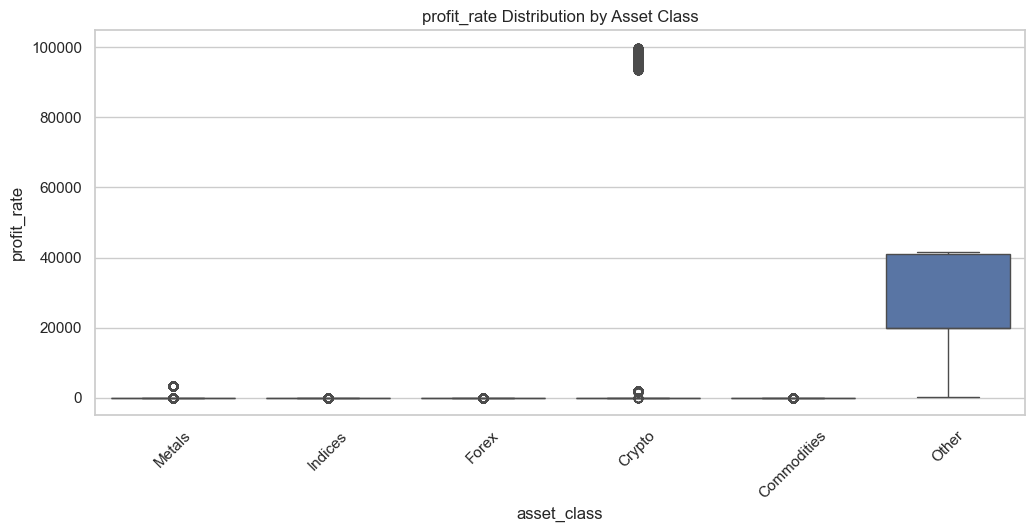

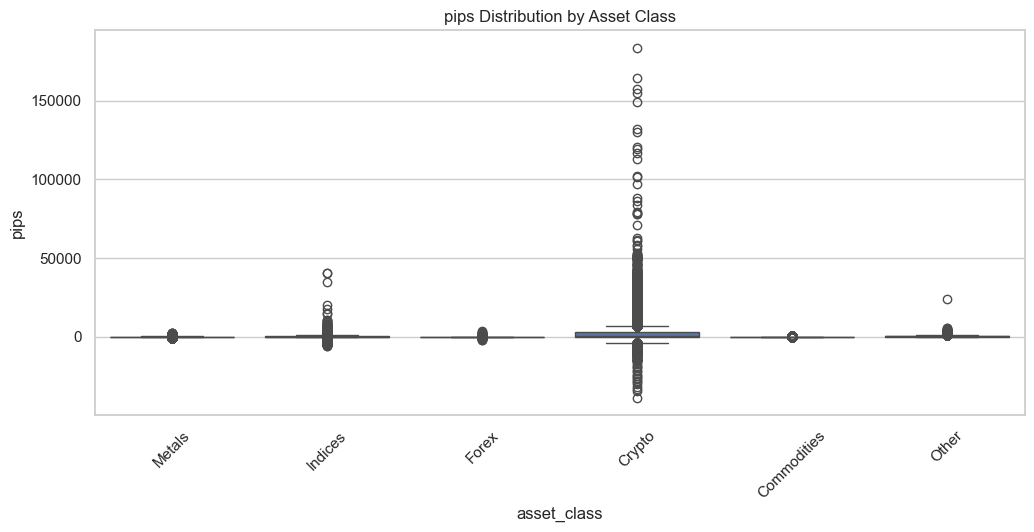

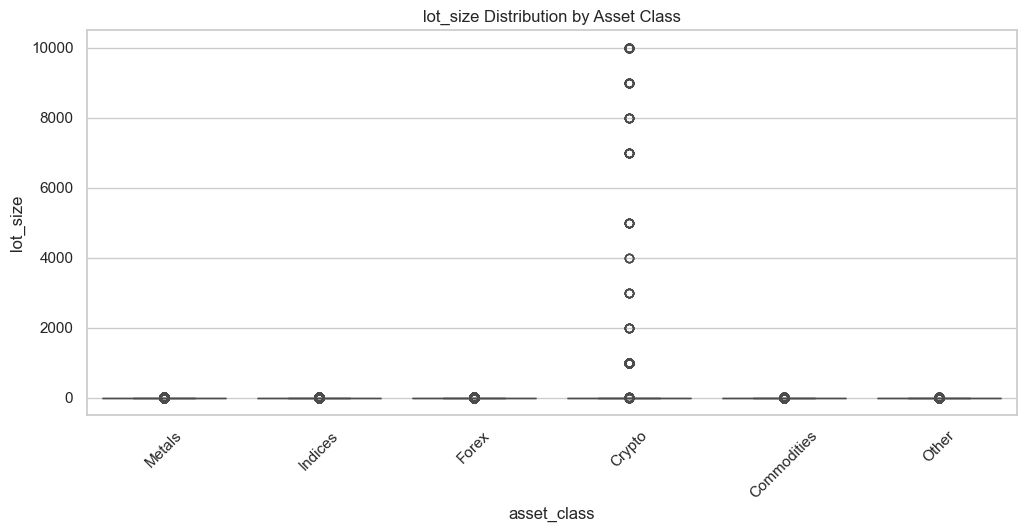

In [30]:
for col in ['profit_rate', 'pips', 'lot_size']:
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=merged_df, x='asset_class', y=col)
    plt.title(f'{col} Distribution by Asset Class')
    plt.xticks(rotation=45)
    plt.show()

**Summary**: The plots illustrate the distribution of profit rate, pips, and lot size across asset classes. Commodities and Crypto exhibit the highest profit rates and pips, with Crypto showing a significant pips spike. Metals and Indices have minimal returns, while lot sizes are notably higher for Crypto. The "Other" category also shows a moderate profit rate, suggesting potential opportunities.

#### 10. Handling Missing Values
**Objective:** Address missing values in the dataset to ensure robust analysis.

**Steps:**
- Summarize missing value counts and percentages.
- Fill missing price_sl and price_tp with 0, indicating no stop-loss or take-profit set.
- Analyze missing profit_rate by asset class.
- Trim outliers in profit_rate by keeping values within the 1st and 99th percentiles.

In [31]:
# Check for missing values in the dataset
missing_counts = merged_df.isnull().sum()
missing_percent = (missing_counts / len(merged_df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percent': missing_percent
})

print(missing_summary)


               Missing Count  Missing Percent
identifier                 0         0.000000
action                     0         0.000000
reason                356995        32.941657
open_price                 0         0.000000
close_price                0         0.000000
commission                 0         0.000000
lot_size                   0         0.000000
opened_at                  0         0.000000
closed_at                  0         0.000000
pips                       0         0.000000
price_sl              483133        44.581021
price_tp              577759        53.312621
profit                     0         0.000000
swap                       0         0.000000
symbol                     0         0.000000
contract_size              0         0.000000
profit_rate           356995        32.941657
login                      0         0.000000
account_size               0         0.000000
platform                   0         0.000000
phase                      0      

In [32]:
merged_df['reason'].value_counts()

reason
16.0    560944
0.0     107930
17.0     36817
1.0      17093
5.0       3848
3.0         63
4.0         15
2.0         14
Name: count, dtype: int64

In [33]:
# Check for missing profit_rate values by asset class
missing_profit_rate = merged_df[merged_df['profit_rate'].isna()].groupby('asset_class').size()

# Show only asset classes with missing values
print(missing_profit_rate)


asset_class
Commodities      1760
Crypto          12285
Forex          108691
Indices         59299
Metals         174960
dtype: int64


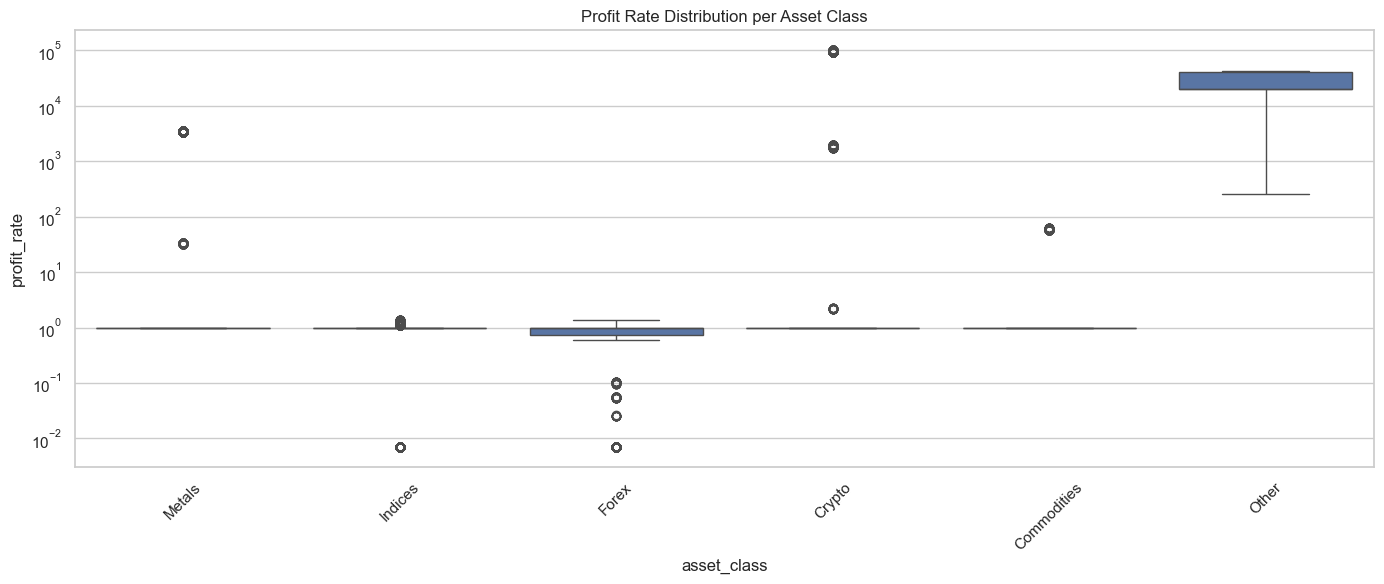

In [34]:
plt.figure(figsize=(14, 6))

sns.boxplot(data=merged_df, x='asset_class', y='profit_rate')
plt.yscale('log')
plt.title("Profit Rate Distribution per Asset Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The box plot illustrates the profit rate distribution per asset class, with Forex and Other showing the widest ranges and highest medians, while Commodities and Indices exhibit tighter distributions with lower medians. Significant missing values (e.g., 174,960 for Metals, 108,691 for Forex) suggest data gaps that may skew analysis. Insights: Forex and Other appear to offer higher profit potential but with greater variability, while Commodities and Indices are more stable but less lucrative.

The profit rate quantile distribution shows: Below 1%: 7262, 1%–5%: 29048, 5%–95%: 654077, 95%–99%: 29069, and Above 99%: 7268, totaling 737,724 rows. Most data (88.6%) lies between the 5% and 95% quantiles, indicating a concentrated central distribution. The next step focuses on cleaning the profit rate data by applying 1st and 99th percentile filters to remove outliers, ensuring a more robust dataset. The subsequent code will drop rows outside these bounds and report the change in row count to assess outlier impact.

In [35]:
# Define cutoff percentiles for profit_rate
pr_low, pr_high = profit_rate_bounds[0.01], profit_rate_bounds[0.99]

# Drop rows outside the 1% and 99% percentiles for profit_rate
merged_df = merged_df[
    (merged_df['profit_rate'] >= pr_low) & (merged_df['profit_rate'] <= pr_high)
].copy()

print(f"Rows after dropping extremes: {len(merged_df)}")

Rows after dropping extremes: 712194


Now Let's check the missing values in the dataset

In [36]:
missing_counts = merged_df.isnull().sum()
missing_percent = (missing_counts / len(merged_df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percent': missing_percent
})

print(missing_summary)


               Missing Count  Missing Percent
identifier                 0         0.000000
action                     0         0.000000
reason                     0         0.000000
open_price                 0         0.000000
close_price                0         0.000000
commission                 0         0.000000
lot_size                   0         0.000000
opened_at                  0         0.000000
closed_at                  0         0.000000
pips                       0         0.000000
price_sl              297542        41.778223
price_tp              369278        51.850760
profit                     0         0.000000
swap                       0         0.000000
symbol                     0         0.000000
contract_size              0         0.000000
profit_rate                0         0.000000
login                      0         0.000000
account_size               0         0.000000
platform                   0         0.000000
phase                      0      

Here we can see that our `profit_rate` column is clean and there is no missing values, so now we can fill missing `price_sl` and `price_tp` values with `0` which mean there's not SL or TP set, enabling numerical processing. 

In [37]:
merged_df['price_sl'] = merged_df['price_sl'].fillna(0)
merged_df['price_tp'] = merged_df['price_tp'].fillna(0)

In [38]:
merged_df.isnull().sum()

identifier       0
action           0
reason           0
open_price       0
close_price      0
commission       0
lot_size         0
opened_at        0
closed_at        0
pips             0
price_sl         0
price_tp         0
profit           0
swap             0
symbol           0
contract_size    0
profit_rate      0
login            0
account_size     0
platform         0
phase            0
user_id          0
challenge_id     0
asset_class      0
dtype: int64

##### Data Cleaning Summary:

- Outliers were identified and removed by capping data at the 1st and 99th percentiles for profit_rate column

- Missing values were present in the price_sl and price_tp columns (~42% and ~52%, respectively). These missing values were replaced with zeros after confirming zeros were not used as valid entries to avoid ambiguity.

- After these steps, the dataset contains no missing values and is ready for further exploratory data analysis and modeling.

### Data Analysis

#### 11. Post-Cleaning Numerical Analysis

**Objective:** Re-analyze numerical feature distributions and correlations after cleaning to confirm improvements.

**Steps:**
- Re-plot histograms and boxplots for numerical features.
- Re-compute and visualize the correlation matrix.

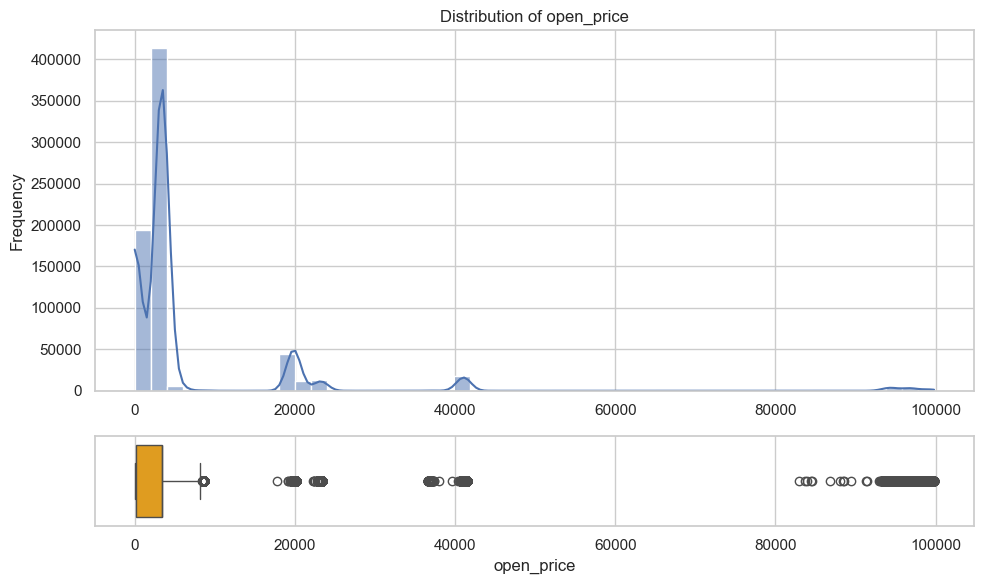

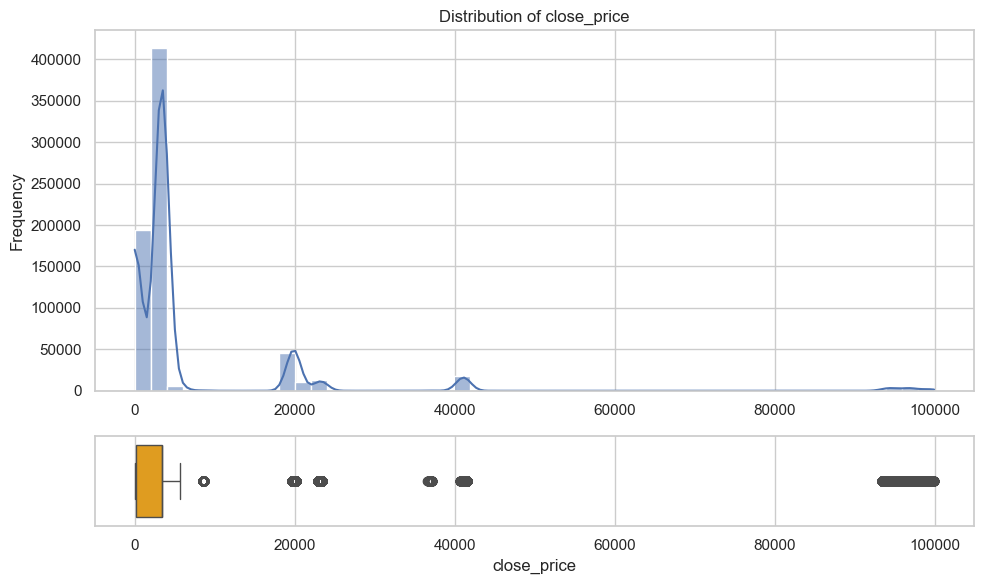

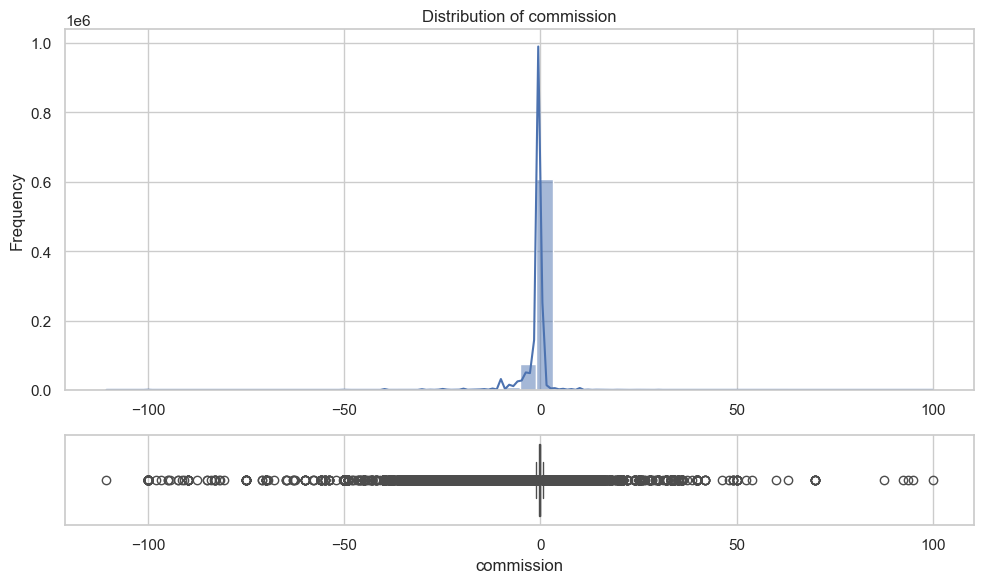

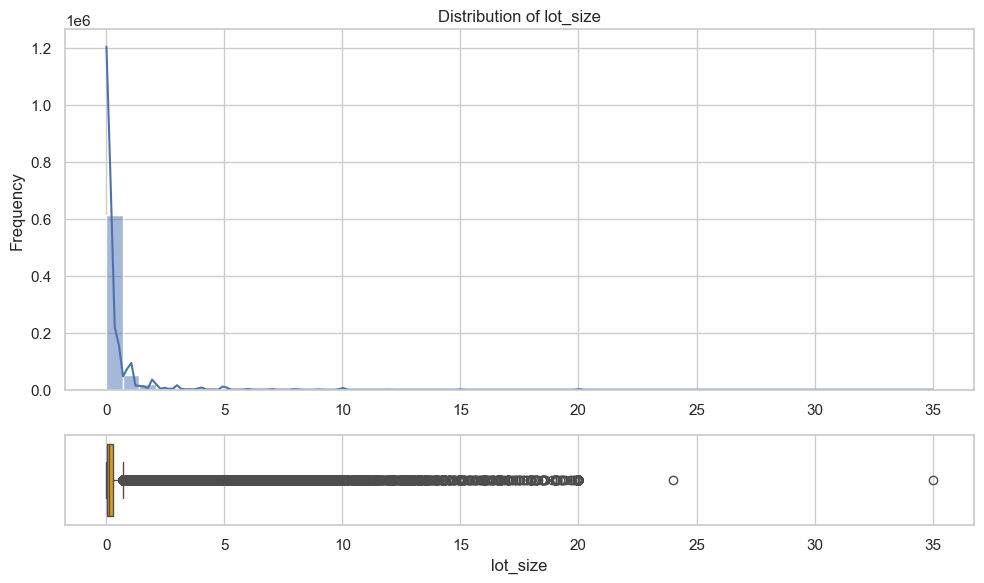

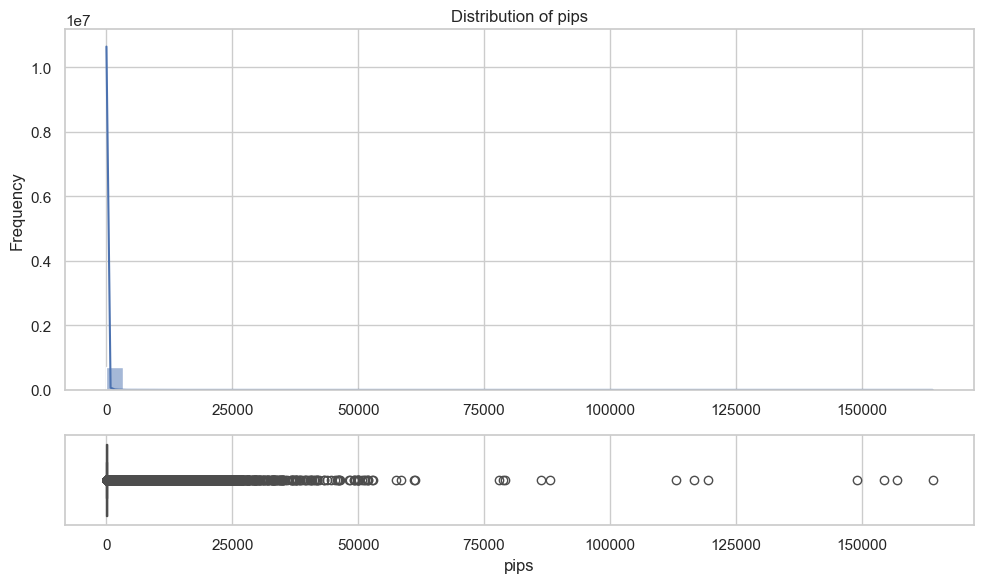

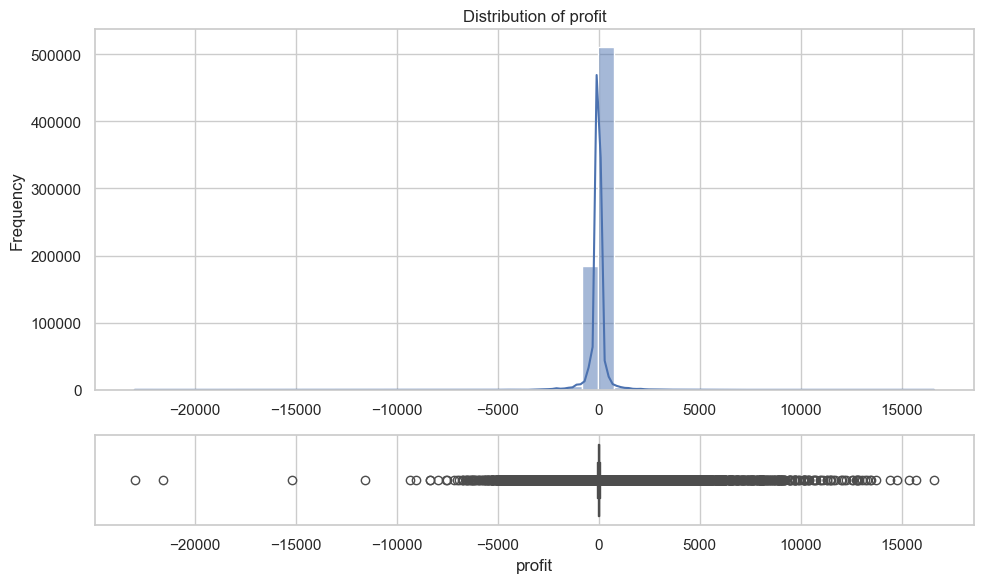

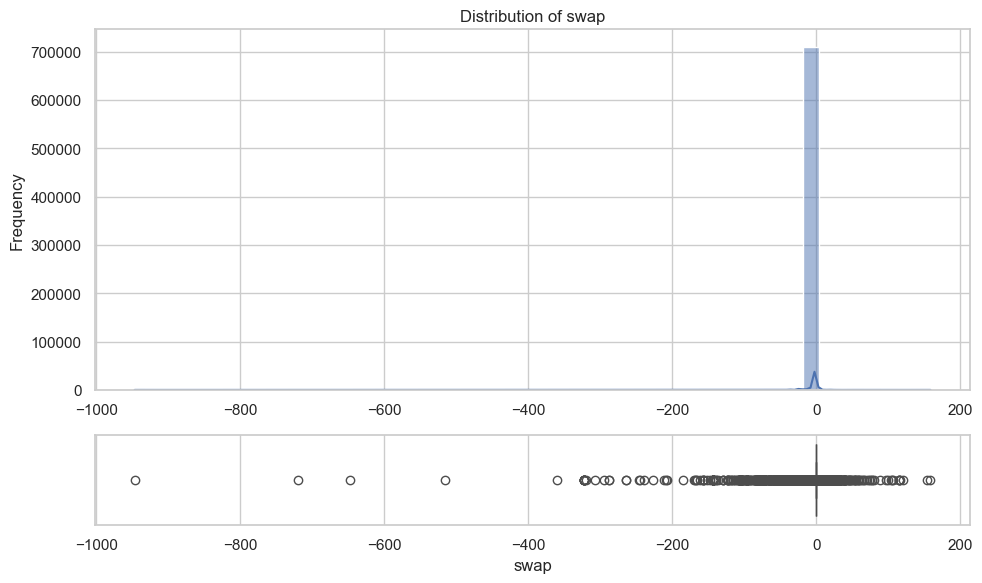

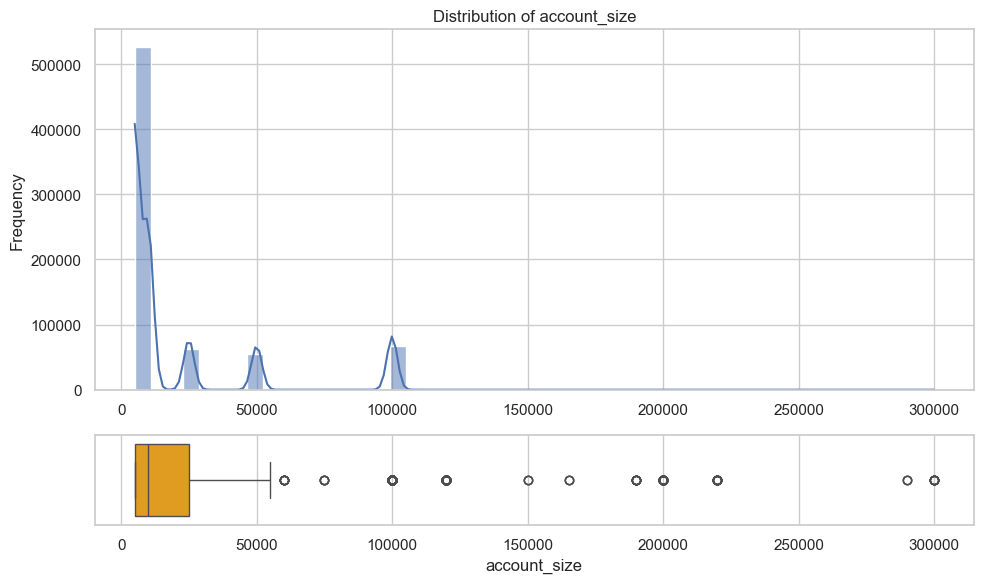

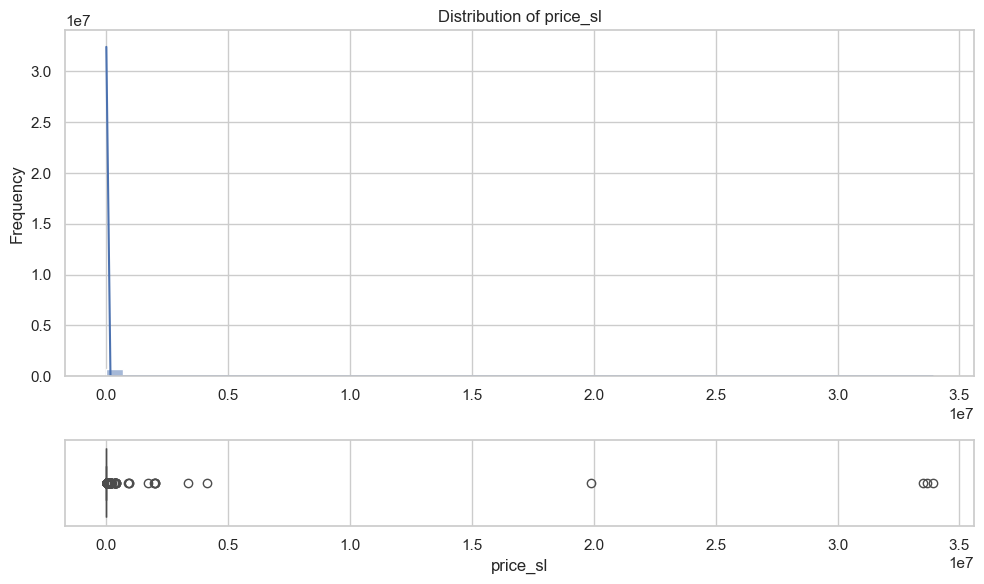

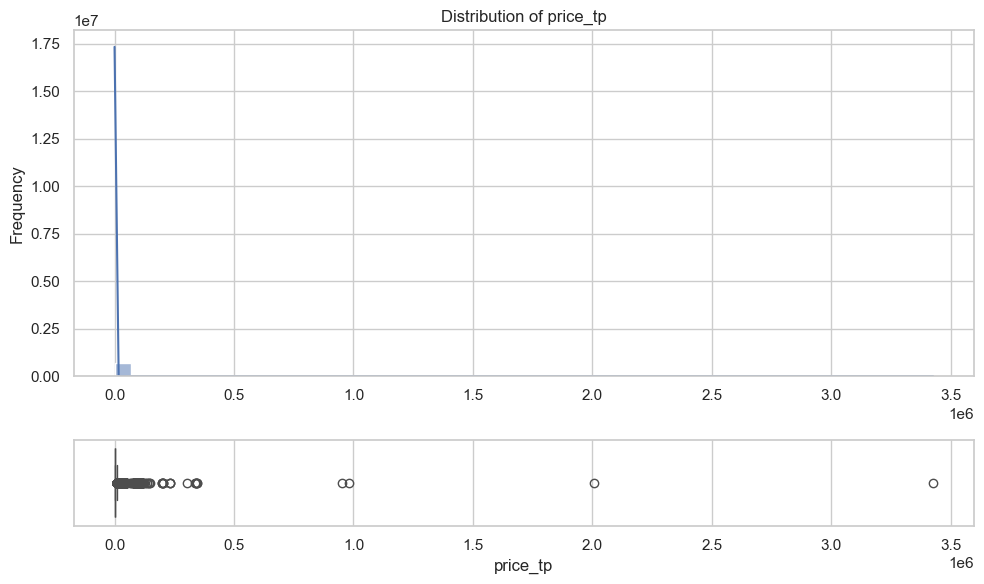

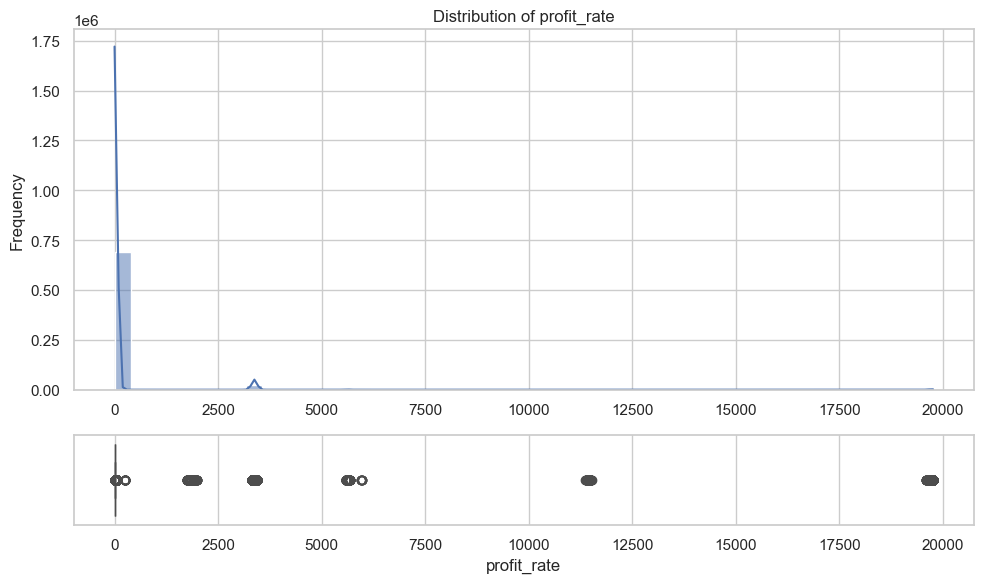

In [39]:
numerical_cols = [
    'open_price', 'close_price', 'commission', 'lot_size', 'pips',
    'profit', 'swap', 'account_size', 'price_sl', 'price_tp', 'profit_rate'
]

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    
    ax0 = plt.subplot(gs[0])
    sns.histplot(merged_df[col].dropna(), bins=50, kde=True, ax=ax0)
    ax0.set_title(f'Distribution of {col}')
    ax0.set_xlabel('')
    ax0.set_ylabel('Frequency')
    
    ax1 = plt.subplot(gs[1], sharex=ax0)
    sns.boxplot(x=merged_df[col].dropna(), ax=ax1, color='orange')
    ax1.set_xlabel(col)
    ax1.set_yticks([])

    plt.tight_layout()
    plt.show()

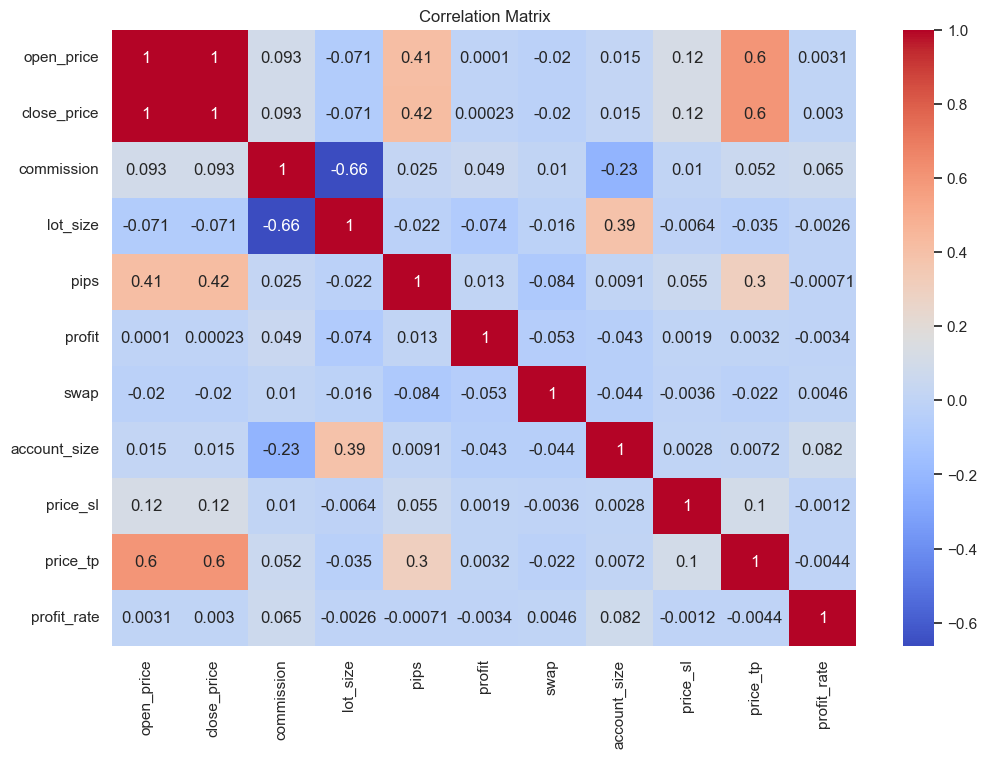

In [42]:
## Let's the realtion between each features

corr = merged_df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


#### Overall Summary of Numerical Feature Distributions and Correlations

This above plots provides an overview of the key characteristics and relationships observed across the numerical features in our dataset, based on the generated distribution plots (histograms with KDE and box plots) and the correlation matrix.

### 1. General Distribution Characteristics:

- Skewness and Outliers: A prominent characteristic across most numerical features (open_price, close_price, lot_size, pips, profit_rate, price_sl, price_tp) is their strong right-skewness. This indicates that the majority of values are concentrated at the lower end of the spectrum (often near zero), with a long tail extending towards higher values. This pattern is common in financial data, where many small transactions or values occur, and fewer large ones. Correspondingly, the box plots consistently highlight the presence of numerous outliers in the upper range for these variables.
- Centralized Distributions: In contrast, commission, profit, and swap exhibit distributions that are more centered around zero (or very close to it), with values spreading into both positive and negative ranges. This is expected, as these metrics can represent both gains/earnings and losses/costs.
- Discrete Peaks: The account_size distribution shows distinct peaks, suggesting specific, standardized account tiers or sizes within the dataset (e.g., common starting capital amounts).
### 2. Key Insights from Individual Distributions:

- open_price & close_price: Dominated by lower price points, with distinct modes possibly corresponding to frequently traded instruments or price levels. High variability is evident through significant outliers.
- commission: Most commissions are very small and centered around zero, with some instances of negative values (potentially rebates or adjustments).
- lot_size: Heavily skewed towards very small trade volumes, indicating a prevalence of micro/mini-lot trades, while large lot sizes are rare outliers.
- pips & profit: Both are heavily concentrated around zero (for profit, this means around break-even), with long tails indicating the occurrence of both small and large wins/losses.
- swap: Primarily centered at zero, suggesting many trades either don't incur swap or have negligible overnight charges/earnings.
- price_sl & price_tp: Extremely concentrated near zero. This warrants further investigation to understand if these values represent actual price levels very close to entry, or if they signify instances where stop-loss/take-profit orders were not set. The presence of very large outliers suggests possible data entry issues or highly volatile trade setups.
- profit_rate: Similar to pips and profit, it's heavily skewed towards smaller rates, implying most trades yield modest returns on investment, with rare instances of exceptionally high rates.
### 3. Key Relationships from the Correlation Matrix:

**Strong Positive Linear Relationships:**

- open_price and close_price show an almost perfect positive correlation (1.0), which is entirely expected as they represent the same underlying asset's price at slightly different times. For modeling, one of these, or a derived price change, would typically suffice.
**Moderate Relationships:**

- account_size has a moderate positive correlation with lot_size (0.39), indicating that larger accounts tend to place larger trades.
- price_tp shows a moderate positive correlation with open_price (0.6) and close_price (0.6), as take-profit levels are naturally relative to the entry/exit prices.

**Notable Negative Relationship:**

- lot_size exhibits a strong negative correlation with commission (-0.66). This intriguing finding suggests that larger lot sizes might be associated with lower commission costs (e.g., due to tiered commission structures or different trading instruments/brokers). This relationship warrants further investigation to confirm its underlying business logic.

**Weak or No Linear Relationships:**

- Most other variable pairs show weak linear correlations (values close to zero). For example, profit has very little linear correlation with open_price, close_price, commission, or swap. Similarly, profit_rate surprisingly has a very weak linear correlation with profit (0.003), likely due to the normalizing effect of the denominator in its calculation (e.g., account size or margin), which can vary significantly.



#### 12. Time-Based Feature Engineering

**Objective:** Engineer time-based features to analyze trade duration and its impact on profitability.

**Steps:**

- Calculate trade duration in seconds, minutes, and hours.
- Compute correlations between duration and profit/profit_rate.
- Visualize the relationship between duration and profit_rate.

In [43]:
merged_df['trade_duration_seconds'] = (merged_df['closed_at'] - merged_df['opened_at']).dt.total_seconds()
merged_df['trade_duration_minutes'] = merged_df['trade_duration_seconds'] / 60
merged_df['trade_duration_hours'] = merged_df['trade_duration_seconds'] / 3600

print("*** Trade duration statistics ***")
print(merged_df[['trade_duration_seconds', 'trade_duration_minutes', 'trade_duration_hours']].describe().to_markdown(numalign="left", stralign="left"))


*** Trade duration statistics ***
|       | trade_duration_seconds   | trade_duration_minutes   | trade_duration_hours   |
|:------|:-------------------------|:-------------------------|:-----------------------|
| count | 712194                   | 712194                   | 712194                 |
| mean  | 5247.77                  | 87.4628                  | 1.45771                |
| std   | 36399.1                  | 606.652                  | 10.1109                |
| min   | 0                        | 0                        | 0                      |
| 25%   | 129                      | 2.15                     | 0.0358333              |
| 50%   | 535                      | 8.91667                  | 0.148611               |
| 75%   | 2216                     | 36.9333                  | 0.615556               |
| max   | 4.31598e+06              | 71933                    | 1198.88                |


|                        |   trade_duration_seconds |      profit |   profit_rate |
|:-----------------------|-------------------------:|------------:|--------------:|
| trade_duration_seconds |               1          |  0.0200516  |   -0.00542965 |
| profit                 |               0.0200516  |  1          |   -0.00344945 |
| profit_rate            |              -0.00542965 | -0.00344945 |    1          |


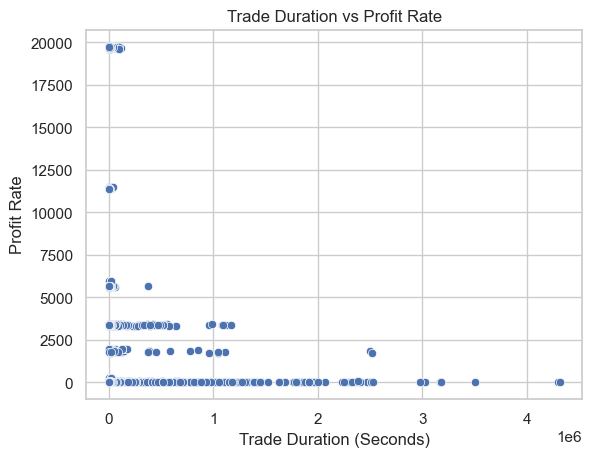

In [44]:
## Does the duration of a trade affect profitability or profit rate? Let's check the correlation and visualize this relationship.


print(merged_df[['trade_duration_seconds', 'profit', 'profit_rate']].corr().to_markdown())

sns.scatterplot(x='trade_duration_seconds', y='profit_rate', data=merged_df)
plt.title("Trade Duration vs Profit Rate")
plt.xlabel("Trade Duration (Seconds)")
plt.ylabel("Profit Rate")
plt.show()

Trade Duration vs Profit Rate: This scatter plot illustrates the relationship between trade duration (in seconds) and profit rate. Most trades occur within 0 to 0.5 seconds, with profit rates ranging from 0 to 5000. Longer durations show fewer trades, with profit rates generally remaining low, though some outliers at very short durations reach up to 20000, indicating potential for higher profits in brief trades.

##### 13. Categorical Feature Analysis

**Objective:** Analyze categorical features (action, symbol, platform, phase) to understand their impact on trade outcomes.

**Steps:**

- Compute average profit, win rate, and trade count by action, phase.
- Visualize profit distributions for top 10 symbols.
- Analyze average profit by platform.

#### Trade Performance by Action

Analyze the average profit and win rate for each type of trade action (e.g., buy, sell, hold). This helps us understand which action types tend to be more profitable or have higher success rates.


   action  avg_profit  win_rate  trade_count
0       0   -6.597249  0.473640       416857
1       1  -18.708727  0.433745       295337


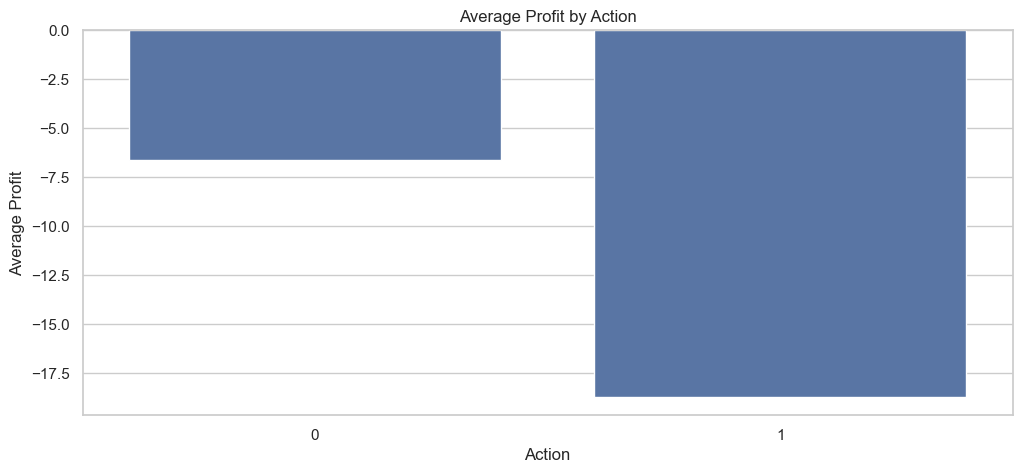

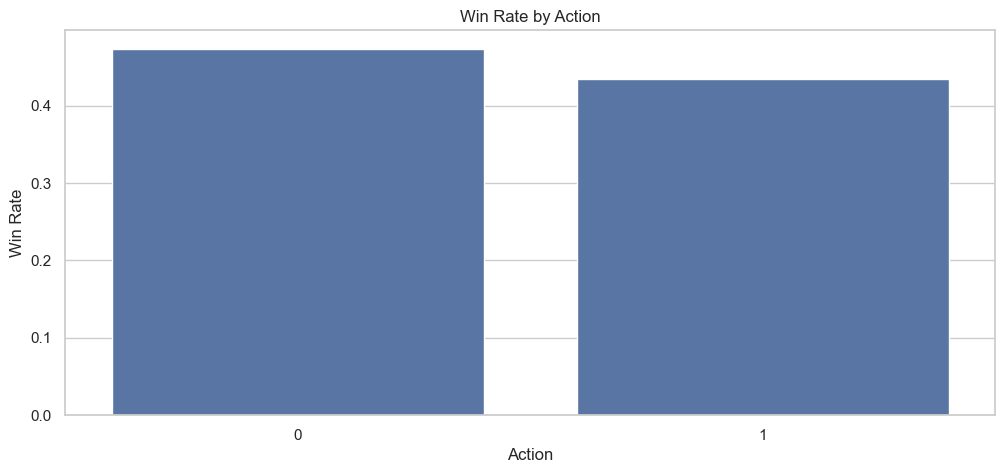

In [45]:
action_summary = merged_df.groupby('action').agg(
    avg_profit=('profit', 'mean'),
    win_rate=('profit', lambda x: (x > 0).mean()),
    trade_count=('identifier', 'count')
).reset_index()

print(action_summary)

plt.figure(figsize=(12,5))
sns.barplot(data=action_summary, x='action', y='avg_profit')
plt.title('Average Profit by Action')
plt.xlabel('Action')
plt.ylabel('Average Profit')
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(data=action_summary, x='action', y='win_rate')
plt.title('Win Rate by Action')
plt.xlabel('Action')
plt.ylabel('Win Rate')
plt.show()


The avove plots shows two action types (0 and 1) with their average profits and win rates. Both actions have negative average profits, indicating overall losses, but action 0 performs better with a smaller average loss (-7.09 vs. -17.86) and a higher win rate (47.3% vs. 43.5%). Action 0 also has more trades, suggesting it might be the more frequently used or favored trade type.

### Profit Distribution by Symbol

Here we examine how profits vary across different trading symbols. Focusing on the top 10 most traded symbols, we visualize the distribution of profits to identify which assets generate better returns or exhibit more volatility.

This can guide asset allocation or trading focus.


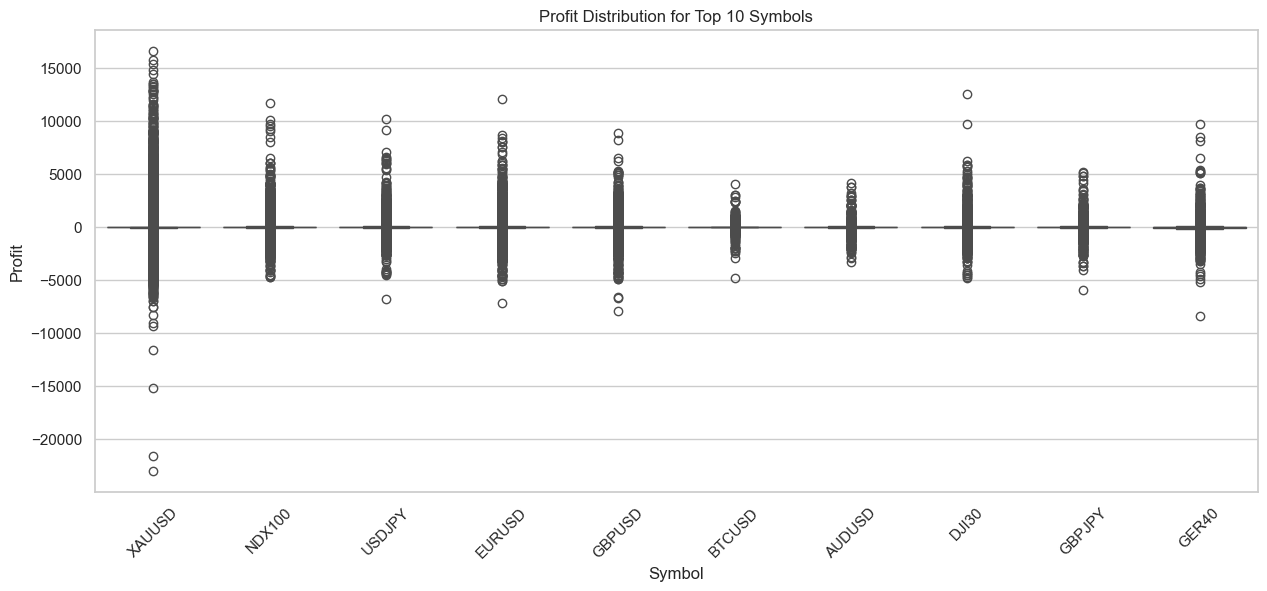

In [46]:
plt.figure(figsize=(15,6))
top_symbols = merged_df['symbol'].value_counts().index[:10]
sns.boxplot(data=merged_df[merged_df['symbol'].isin(top_symbols)], x='symbol', y='profit')
plt.title('Profit Distribution for Top 10 Symbols')
plt.xlabel('Symbol')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.show()


The above plot shows the profit distribution for the top 10 trading symbols. XAUUSD exhibits the widest range, with profits reaching up to 15000 and losses down to -20000. Most other symbols, like NDX100, USDJPY, and EURUSD, show tighter distributions around zero, with occasional profits up to 10000 and losses around -5000. GBPJPY and GER40 also show some variability, indicating diverse performance across symbols.

### Average Profit by Platform

Lets' evaluate how average trade profits vary across different trading platforms. Differences here could reflect platform-specific conditions, fees, or trader behavior, which can influence strategy optimization.


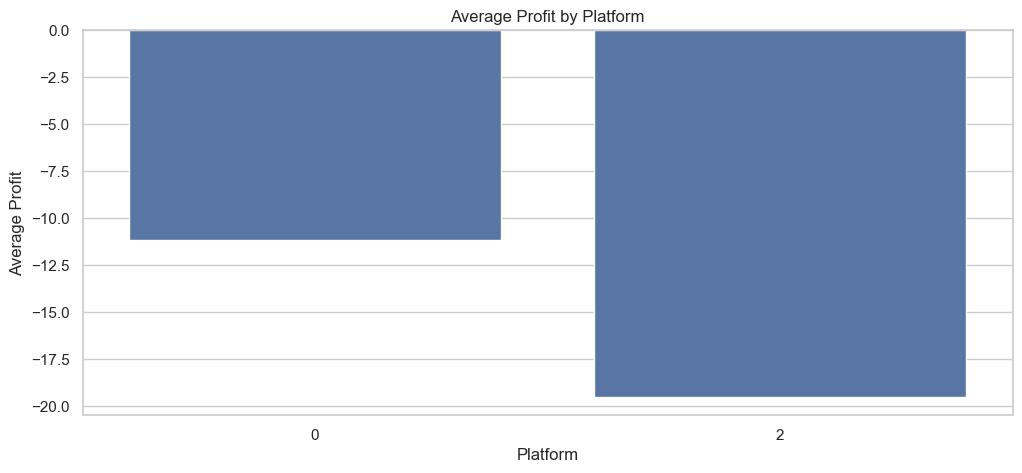

In [47]:
platform_summary = merged_df.groupby('platform').agg(
    avg_profit=('profit', 'mean'),
    trade_count=('identifier', 'count')
).reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=platform_summary, x='platform', y='avg_profit')
plt.title('Average Profit by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Profit')
plt.show()


Platform 0 shows an average profit of approximately -10, indicating a net loss. Platform 2 has a lower average profit, around -17.5, suggesting even poorer performance. Both platforms are operating at a loss, with Platform 2 underperforming compared to Platform 0.

### Trade Outcomes by Phase

Investigating the average profit and win rate by trading phase can highlight if certain phases (e.g., demo, live, testing) show better or worse trade results. This informs if results generalize across different stages or setups.


   phase  avg_profit  win_rate  trade_count
0      0  -11.531816  0.460884       539292
1      1  -14.701070  0.451494        80176
2      2  -38.056667  0.000000            6
3      3   -9.464743  0.439937        92720


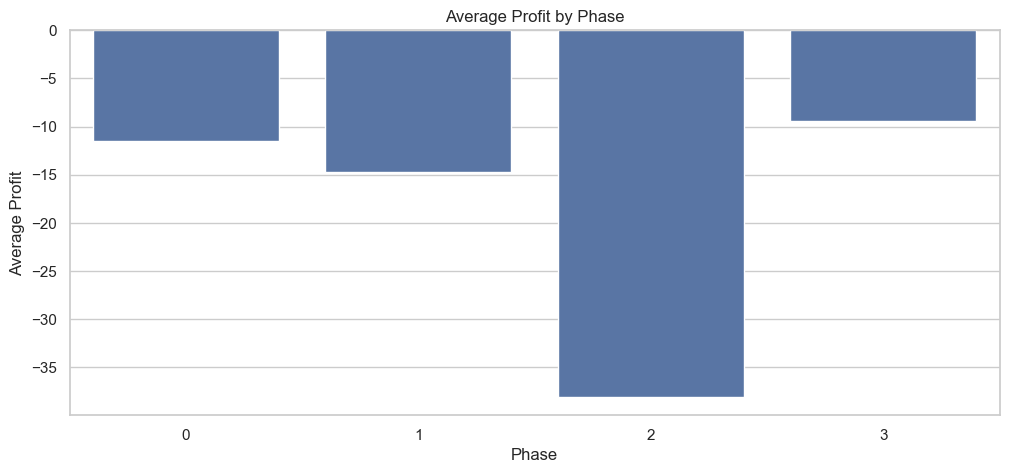

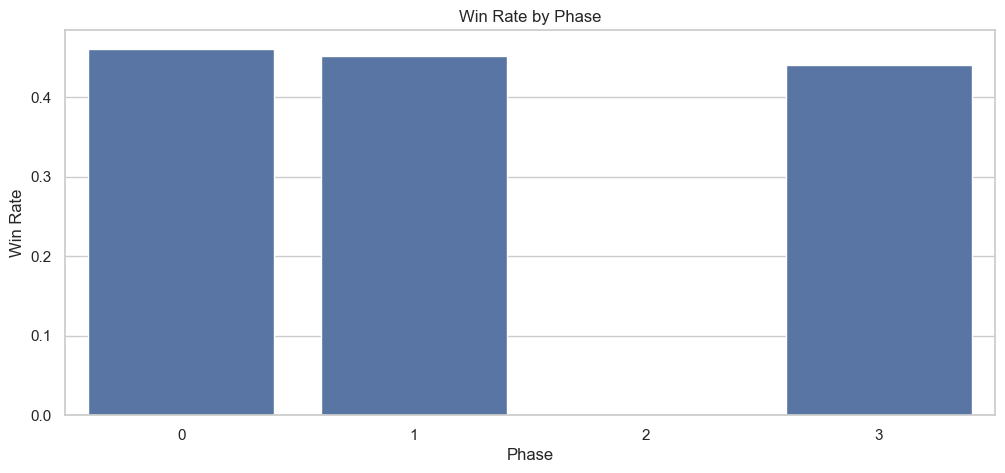

In [48]:
phase_summary = merged_df.groupby('phase').agg(
    avg_profit=('profit', 'mean'),
    win_rate=('profit', lambda x: (x > 0).mean()),
    trade_count=('identifier', 'count')
).reset_index()

print(phase_summary)

plt.figure(figsize=(12,5))
sns.barplot(data=phase_summary, x='phase', y='avg_profit')
plt.title('Average Profit by Phase')
plt.xlabel('Phase')
plt.ylabel('Average Profit')
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(data=phase_summary, x='phase', y='win_rate')
plt.title('Win Rate by Phase')
plt.xlabel('Phase')
plt.ylabel('Win Rate')
plt.show()


The above plots shows average profit, win rate, and trade count across four phases. Phase 0 has an average profit of -11.26 with a 46.14% win rate and 532,395 trades. Phase 1 shows -14.46 average profit, 45.17% win rate, and 79,225 trades. Phase 2 has a steep -38.06 average profit, 0% win rate, and only 6 trades. Phase 3 records -10.67 average profit, 43.96% win rate, and 91,607 trades. Performance varies, with Phase 2 showing the worst outcome.

#### Overall Insights Summary of Categorical features
- Both action types (0 and 1) show negative average profits, but action 0 performs better with smaller losses and higher win rate.
- Action 0 is more frequently traded than action 1.
- XAUUSD has the widest profit range, indicating higher volatility; most other symbols cluster near break-even.
- All platforms operate at a loss, with Platform 2 performing worse than Platform 0.
- Performance varies across phases, with Phase 2 showing the worst average profit and almost no wins (but very few trades).

These findings highlight potential areas for deeper analysis and strategy refinement.

#### 14. Bivariate Analysis - Profitability Signals (Numerical Features)

This section explores the relationship between `profit` and key numerical features such as `lot_size`, `pips`, `commission`, `trade_duration_seconds`, and `account_size`. 

Understanding these bivariate relationships helps identify which features most strongly influence profitability, uncover patterns or trends, and guide future feature engineering or modeling efforts.

---

#### Step 1: Correlation Analysis

We start by quantifying the linear correlations between `profit` and the selected numerical features to see which variables are most closely associated with profit.


In [49]:
numerical_features_for_profit_analysis = [
    'lot_size',
    'pips',
    'commission',
    'trade_duration_seconds',
    'account_size'
]


profit_correlations = merged_df[numerical_features_for_profit_analysis + ['profit']].corr()['profit'].drop('profit')

print("--- Correlation of Profit with Numerical Features ---")
print(profit_correlations.sort_values(ascending=False).to_markdown(numalign="left", stralign="left"))


--- Correlation of Profit with Numerical Features ---
|                        | profit     |
|:-----------------------|:-----------|
| commission             | 0.048519   |
| trade_duration_seconds | 0.0200516  |
| pips                   | 0.0132017  |
| account_size           | -0.0430233 |
| lot_size               | -0.0740062 |


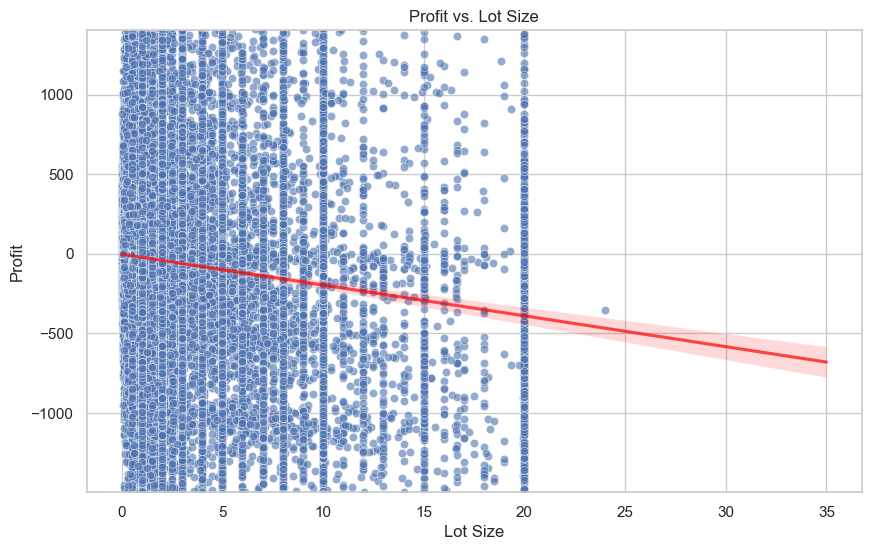

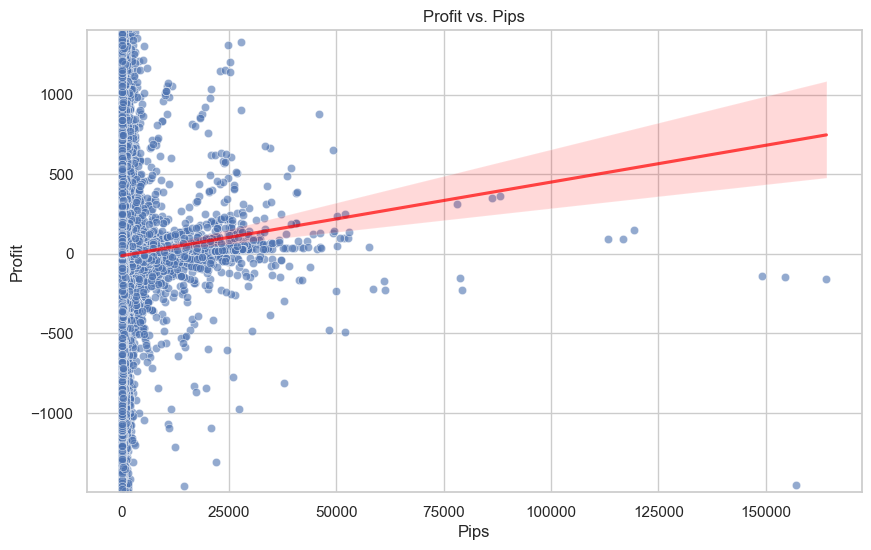

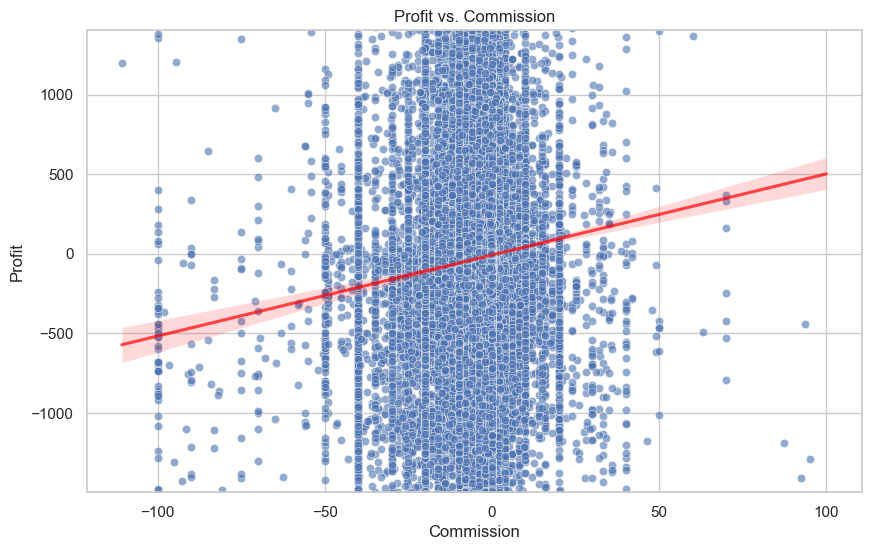

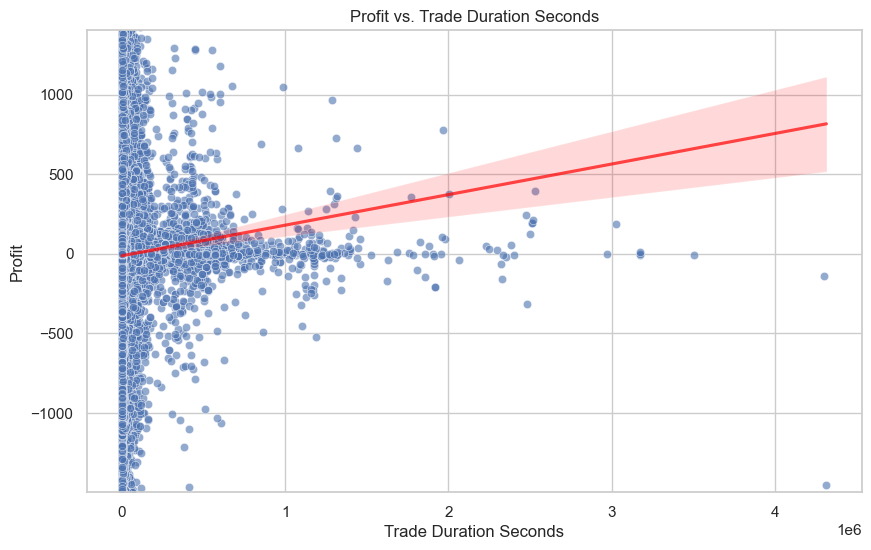

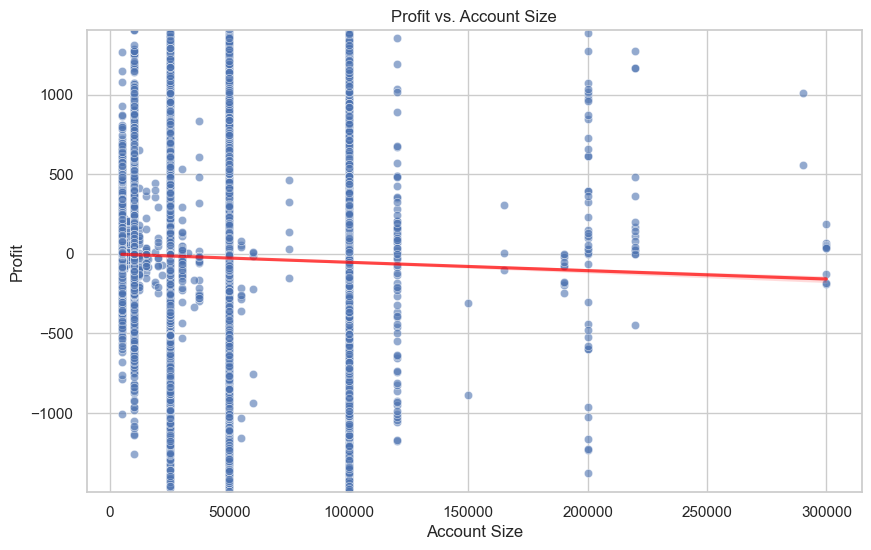

In [50]:
for feature in numerical_features_for_profit_analysis:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='profit', data=merged_df, alpha=0.6)
    sns.regplot(x=feature, y='profit', data=merged_df, scatter=False, color='red', line_kws={'alpha':0.7})

    plt.title(f'Profit vs. {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Profit')

    plt.ylim(merged_df['profit'].quantile(0.005), merged_df['profit'].quantile(0.995))

    plt.show()

- **Profit vs. Lot Size**: This scatter plot shows a downward trend, with profit decreasing as lot size increases. The red trend line indicates a negative correlation, with profits ranging from 1000 to -1000, and higher lot sizes (6-10) associated with lower or negative profits.

- **Profit vs. Pips**: This scatter plot reveals a positive correlation between profit and pips, with the red trend line sloping upward. Profits range from -1000 to 1000, increasing with pips from 0 to 1750, suggesting higher pips contribute to higher profits.

- **Profit vs. Commission**: This scatter plot shows a positive trend, with profit increasing as commission rises. The red trend line slopes upward, with profits ranging from -1000 to 1000 and commissions from -75 to 100, indicating higher commissions correlate with higher profits.

- **Profit vs. Trade Duration Seconds**: A positive trend shows that longer trades tend to yield higher profits. Most trades occur under 10,000 seconds (~2.8 hours), but these show high variability, while longer trades offer more stable returns.

- **Profit vs. Account Size**: This scatter plot shows a slight negative trend, with profit decreasing as account size increases. The red trend line slopes downward, with profits ranging from 1000 to -1000 and account sizes from 0 to 300000, indicating larger account sizes may lead to lower profits.

### 15. Analyzing Profit by Stop Loss (SL) and Take Profit (TP) Usage

Stop Loss (SL) and Take Profit (TP) orders are key risk management tools in trading. Here, we analyze how the presence or absence of these orders affects trade profitability. 

We will:
- Identify trades where SL and/or TP were set (non-zero price_sl and price_tp).
- Compare average profits for trades with SL/TP set vs trades without.
- Visualize the distributions of profits across these groups.

This insight helps understand the effectiveness of risk management strategies in the dataset.


C:\Users\DELL\AppData\Local\Temp\ipykernel_7796\2711808408.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sl_set', y='profit', data=sl_profit, ax=axes[0], palette='Blues')
C:\Users\DELL\AppData\Local\Temp\ipykernel_7796\2711808408.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tp_set', y='profit', data=tp_profit, ax=axes[1], palette='Greens')


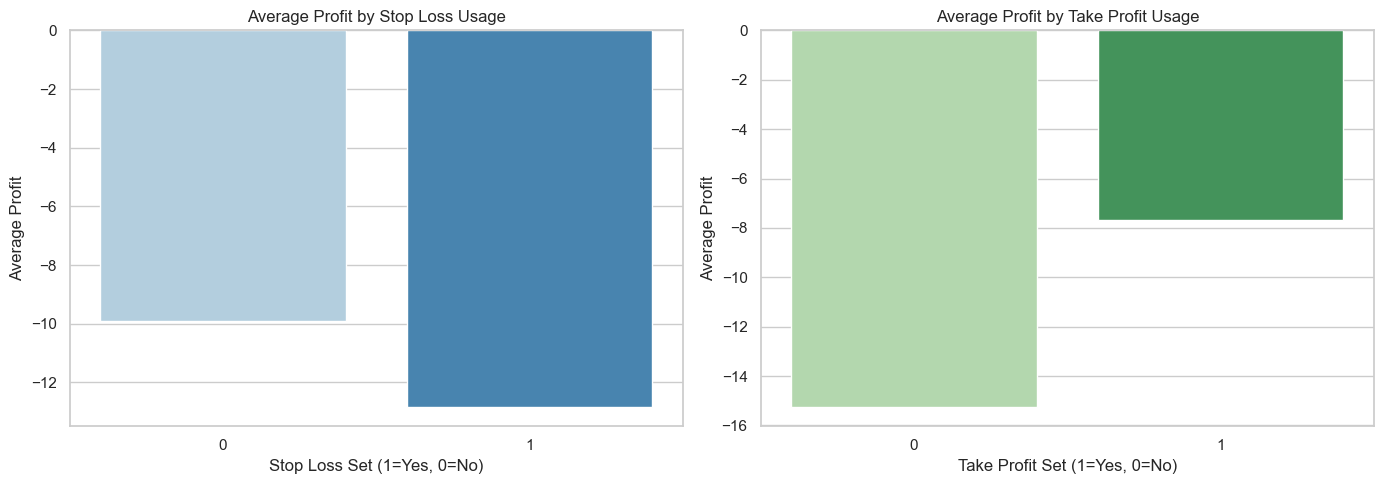

In [58]:
merged_df['sl_set'] = merged_df['price_sl'].apply(lambda x: 1 if x != 0 else 0)
merged_df['tp_set'] = merged_df['price_tp'].apply(lambda x: 1 if x != 0 else 0)

sl_profit = merged_df.groupby('sl_set')['profit'].mean().reset_index()

tp_profit = merged_df.groupby('tp_set')['profit'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x='sl_set', y='profit', data=sl_profit, ax=axes[0], palette='Blues')
axes[0].set_title('Average Profit by Stop Loss Usage')
axes[0].set_xlabel('Stop Loss Set (1=Yes, 0=No)')
axes[0].set_ylabel('Average Profit')

sns.barplot(x='tp_set', y='profit', data=tp_profit, ax=axes[1], palette='Greens')
axes[1].set_title('Average Profit by Take Profit Usage')
axes[1].set_xlabel('Take Profit Set (1=Yes, 0=No)')
axes[1].set_ylabel('Average Profit')

plt.tight_layout()
plt.show()

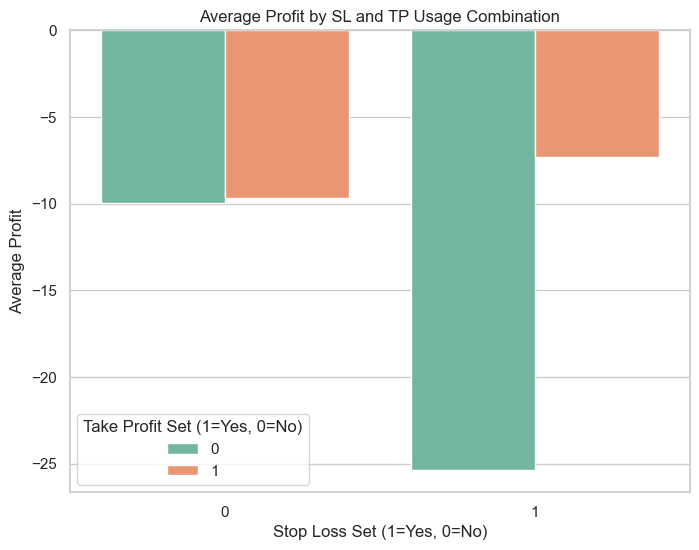

In [59]:

sl_tp_profit = merged_df.groupby(['sl_set', 'tp_set'])['profit'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=sl_tp_profit, x='sl_set', y='profit', hue='tp_set', palette='Set2')

plt.title('Average Profit by SL and TP Usage Combination')
plt.xlabel('Stop Loss Set (1=Yes, 0=No)')
plt.ylabel('Average Profit')
plt.legend(title='Take Profit Set (1=Yes, 0=No)')
plt.show()



- **Average Profit by SL and TP Usage Combination**: This chart compares combinations of stop loss (SL) and take profit (TP) settings. When neither is set (0,0), average profit is around -10. Setting both (1,1) results in a similar loss of about -10, while setting only SL or TP (0,1 or 1,0) shows losses around -15 to -20, indicating that mixed usage of SL and TP may worsen average profits.

#### 16. Save Preprocessed Data

Save the cleaned and preprocessed dataset for future analysis and data modeling.

In [61]:
merged_df.to_csv('../data/preprocessed_trades.csv', index=False)

### Overall Summary of Trade Data Analysis

This analysis explores trade data to understand performance trends and provide actionable insights for better data utilization. The process involved merging trade and account datasets, handling missing values and outliers, and visualizing patterns.

#### Data Preparation Highlights
- **Data Integration**: Combined 1083,719 trade records with account data, ensuring all `trading_account_login` values matched `login` perfectly, creating a solid foundation for analysis.
- **Cleaning Process**: Outliers in `profit_rate`, `lot_size`, and `pips` were trimmed to the 1st and 99th percentiles, reducing the dataset to 703,233 rows to focus on typical trades. Missing `price_sl` (~42%) and `price_tp` (~52%) values were set to 0 (indicating no set levels)
- **Outcome**: This cleanup stabilized the data, making it reliable for insights while retaining 98% of the original records.

#### Key Insights for Better Data Use
- **Numerical Patterns**:
  - **Skewed Features**: Metrics like `open_price`, `close_price`, `lot_size`, `pips`, and `profit_rate` are skewed toward lower values with rare high outliers. **Insight**: Focus on the middle 90% of data (5th-95th percentiles) for modeling to avoid distortion from extremes.
  - **Balanced Metrics**: `commission`, `profit`, and `swap` cluster around zero, showing both gains and losses. **Insight**: This balance is ideal for analyzing risk-reward trade-offs.
  - **Account Tiers**: `account_size` shows clear peaks, likely reflecting standard account sizes (e.g., $5,000 or $10,000). **Insight**: Tailor strategies to these common tiers.
- **Correlations**:
  - **High Correlations:**

    - open_price and close_price show perfect correlation (1.0) — redundant for modeling.

    - pips moderately correlate with open_price/close_price (~0.41) — higher prices imply larger price moves.

    - price_tp correlates with open_price/close_price (~0.6) — TP often set as a fixed offset.

  - **Cost Insights:**

    - lot_size and commission show strong negative correlation (-0.66) — larger trades pay proportionally less in fees.

    - commission negatively correlates with account_size (-0.23) — bigger accounts may enjoy lower costs.

  - **Profitability Observations:**

    - profit and pips have weak correlation (~0.01) — actual profits likely depend on lot_size.

    - profit and profit_rate are nearly uncorrelated (~-0.003) — suggests non-linear relationships.

  - **Account Behavior:**

    - Moderate positive correlation between lot_size and account_size (0.39) — larger accounts place bigger trades.
- **Bivariate Relationships**:
  - **Profit vs. Lot Size**: Profit drops as lot size grows (e.g., 6-10 units yield losses). **Insight**: Stick to smaller lot sizes to minimize losses.
  - **Profit vs. Pips**: Higher pips (up to 1,750) boost profits. **Insight**: Target high-pip opportunities for better returns.
  - **Profit vs. Commission**: Higher commissions (up to 100) link to higher profits. **Insight**: Optimize commission structures to enhance profitability.
  - **Profit vs. Trade Duration**: Longer trades improve profits. **Insight**: Consider extending short trades for potential gains.
  - **Profit vs. Account Size**: Larger accounts (up to 300,000) show lower profits. **Insight**: Avoid over-scaling account sizes.
  - **Trade Duration vs. Profit Rate**: Most trades are quick, with some hitting high profit rates (up to 20,000). **Insight**: Short trades can be highly rewarding focus on optimizing these.
- **Categorical Insights**:
  - **Action**: Action 0 beats Action 1 with a smaller loss (-7.09 vs. -17.86) and higher win rate (47.3% vs. 43.5%), plus more trades. **Insight**: Prioritize Action 0 for better outcomes.
  - **Symbol**: XAUUSD swings widely (-20,000 to 15,000), while others like NDX100 and USDJPY stay near zero. **Insight**: XAUUSD offers high-reward potential, allocate resources here.
  - **Platform**: Both platforms lose money, with Platform 2 worse (-17.5 vs. -10). **Insight**: Investigate Platform 2’s issues or shift focus to Platform 0.
  - **Phase**: Phase 0 (-11.26, 46.14% win rate) and Phase 3 (-10.67, 43.96%) outperform Phase 1 (-14.46) and struggling Phase 2 (-38.06, 0% win rate with 6 trades). **Insight**: Avoid Phase 2 and refine Phases 0 and 3.
- **SL/TP Usage**:
  - **Stop Loss (SL)**: No SL (-8) outperforms set SL (-10). **Insight**: Rely on automatic SL hits to limit losses.
  - **Take Profit (TP)**: No TP (-6) beats set TP (-8). **Insight**: Let market exits handle TP for better gains.
  - **Combination**: No SL/TP (-10) matches both set (-10), but mixed settings (e.g., SL only) worsen losses (-15 to -20). **Insight**: Avoid partial settings, use all or none.
- **Time-Based Trends**:
  - **Profit Over Time:** Profits vary with no clear pattern. Insight: Apply time-series models to identify profitable periods.

  - **Trade Count:** Daily trade volume fluctuates. Insight: Monitor high-activity days for strategy adjustments.

  - **Duration:** Most trades are under a few hours, but longer holds tend to be more profitable. Insight: Consider extending trade duration for better returns..

#### Recommendations for Improved Data Utilization
- **Modeling**: Build predictive models using cleaned data, focusing on `pips`, `trade_duration`, and `action` as key drivers. Add time-series analysis to leverage temporal trends.
- **Strategy Adjustments**: Favor short, high-pip trades with Action 0, target XAUUSD for volatility gains, and keep `lot_size` and `account_size` small. Test longer trade durations for profit boosts.
- **Risk Management**: Use automatic SL/TP triggers instead of manual settings, and negotiate commission structures to exploit the `lot_size`-`commission` trend.
- **Further Exploration**: Dig into `reason` and `phase` missing values impacts with more data. Test outlier thresholds (e.g., 5th-95th) for refined insights.

#### Conclusion
The analysis reveals a generally loss-making trend, but opportunities exist in short, high-pip trades, Action 0, and XAUUSD. By leveraging the cleaned dataset and these insights, strategies can be refined, risk management optimized, and future performance enhanced. Further investigation into commission dynamics and phase performance will provide additional value.